<a href="https://colab.research.google.com/github/kaitken17/colab_stuff/blob/master/sythetic_analysis_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install tensorflow_text

In [64]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

In [65]:
# Skips any tests and just runs function definitions
run_tests = False

# Synthetic Data

#### Function Defs

In [66]:
def generateWordBank(toy_params):
  """ Creates the word bank based on various inputs """

  context_words = toy_params['context_words']
  variable_length = toy_params['variable_length'] if 'variable_length' in toy_params else False
  unordered = toy_params['unordered_class']
  if unordered:
    words = []
    n_unordered = toy_params['n_unordered']
    for i in range(n_unordered):
      words.extend(['kinda'+str(i), 'very'+str(i)])
      # words.extend(['kinda'+str(i), 'very'+str(i), 'bad'+str(i), 'awful'+str(i)])
  else:
    words = ['awful', 'bad', 'good', 'awesome']
  
  # words.extend(['the', 'the2', 'the3', 'the4', 'the5'])
  # words.extend(['the', 'the2', 'the3'])
  words.extend(['the'])

  if context_words:
    words.extend(['not', 'extremely'])

  return words

def make_toy_phrase(toy_params):
  """ Creates a single toy phrase from the word bank """
  
  phrase_length = toy_params['phrase_length']
  words = toy_params['words']
  variable_length = toy_params['variable_length']
  min_phrase_len = toy_params['min_phrase_len']
  the_padding = toy_params['the_padding']

  phrase = []
  
  # Sets phrase length, allowing for variable length
  if variable_length:
    length = min_phrase_len + np.random.randint(phrase_length - min_phrase_len)
  else:
    length = phrase_length
  
  if the_padding:
    length -= 20
    for _ in range(10):
      phrase.append('<noise>')
  
  n_words = len(words)

  for idx in range(length):
    next_word = False
    while not next_word:
      next_word = False

      word_idx = np.random.randint(n_words)
      if words[word_idx] == 'extremely' and idx > 0: # No repeat 'extremely'
        if phrase[idx-1] != 'extremely':
          next_word = True
      elif words[word_idx] == 'not' and idx > 0: # No repeat 'not'
        found_not = False
        for idx2 in range(1, min(4, idx+1)): # Up to 4 words back
          if phrase[idx-idx2]== 'not':
            found_not = True
        if not found_not:
          next_word = True
      elif words[word_idx] != '<EoS>':
        next_word = True
    phrase.append(words[word_idx])

  if the_padding:
    for _ in range(10):
      phrase.append('<noise>')

  # Adds padding at end for variable length phrases
  if variable_length:
    for i in range(phrase_length - length):
      phrase.append('<pad>')
  
  return phrase

def baseWordValues(toy_params):
  """ Generates the base word values which are used to score phrases """
  unordered = toy_params['unordered_class']
  
  if unordered:
    n_unordered = toy_params['n_unordered']
    corr_val = toy_params['corr_val'] if 'corr_val' in toy_params else 0.0
    base_word_vals = {}
    for i in range(n_unordered):
      base_word_vals['kinda'+str(i)] = np.zeros((n_unordered,))
      base_word_vals['kinda'+str(i)][i] = 1
      base_word_vals['very'+str(i)] = np.zeros((n_unordered,))
      base_word_vals['very'+str(i)][i] = 2
      # base_word_vals['bad'+str(i)] = np.zeros((n_unordered,))
      # base_word_vals['bad'+str(i)][i] = -1
      # base_word_vals['awful'+str(i)] = np.zeros((n_unordered,))
      # base_word_vals['awful'+str(i)][i] = -2
    # base_word_vals['kinda01'] = np.zeros((n_unordered,))
    # base_word_vals['kinda01'][0] = 1/2
    # base_word_vals['kinda01'][1] = 1/2
    # base_word_vals['bad0'] = np.zeros((n_unordered,))
    # base_word_vals['bad0'][0] = -1
    # base_word_vals['bad1'] = np.zeros((n_unordered,))
    # base_word_vals['bad1'][1] = -1
    # base_word_vals['kinda01'] = np.asarray([1,1,0,0])
    # base_word_vals['kinda12'] = np.asarray([0,1,1,0])
    # base_word_vals['kinda23'] = np.asarray([0,0,1,1])
    # base_word_vals['kinda03'] = np.asarray([1,0,0,1])
    # base_word_vals['kinda1100'] = np.asarray([1,1,0,0])
    # base_word_vals['kinda0011'] = np.asarray([0,0,1,1])
    # base_word_vals['kinda1010'] = np.asarray([1,0,1,0])
    # base_word_vals['kinda0101'] = np.asarray([0,1,0,1])
    # base_word_vals['kinda0'] = np.asarray([1, corr_val, 0])
    # base_word_vals['kinda1'] = np.asarray([0, 1 - corr_val, 0])
  else:
    base_word_vals = {'awful': -2.0, 'bad': -1.0, 'the': 0, 'good': 1.0, 'awesome': 2.0}

  return base_word_vals

def eval_toy_phrase(toy_phrase, toy_params):
  """ Evaluates a single toy phrase and returns a score """
  max_phrase_length = toy_params['phrase_length']
  unordered = toy_params['unordered_class']
  base_word_vals = toy_params['base_word_vals']

  phrase_length = len(toy_phrase)
  extreme_length = 0 # range of influence of extreme
  not_length = 0 # range of influence of not

  if unordered:
    score = np.zeros((toy_params['n_unordered'],))
  else:
    score = 0

  for idx in range(phrase_length):
    if toy_phrase[idx] in list(base_word_vals.keys()):
      base_score = base_word_vals[toy_phrase[idx]]
      if not_length > 0: 
        base_score = -1 * base_score
      if extreme_length > 0: 
        base_score = 2 * base_score
      score += base_score
    elif toy_phrase[idx] == 'not':
      not_length = 4
    elif toy_phrase[idx] == 'extremely':
      extreme_length = 2
    # elif toy_phrase[idx] == '<EoS>': break
    # elif toy_phrase[idx] == '<pad>': break
    
    if not_length > 0: not_length -= 1 # decays not
    if extreme_length > 0: extreme_length -= 1 # decays extremely
  
  if toy_params['corr_vals'] != {}: # Modifies scores if there are correlation values
    score = correlation_score_mod(score, toy_params)

  return score

def correlation_score_mod(score, toy_params):
  """ Modifies scores based on correlations """ 
  corr_vals = toy_params['corr_vals']
  n_classes = len(score)
  # print('Base score:', score)
  avgs = np.asarray([[1/2*(score0+score1) for score0 in score] for score1 in score])
  new_score = np.copy(score)

  for key in corr_vals:
    class0 = int(key[0])
    class1 = int(key[1])
    corr_val = corr_vals[key]
    avg_score = avgs[class0, class1]
    # print('Average is:', avg_score, 'Correlation value', corr_val)
    rand_coef = 2*np.random.randint(2)
    new_score[class0] = new_score[class0] - corr_val*score[class0] + rand_coef * corr_val * avg_score
    new_score[class1] = new_score[class1] - corr_val*score[class1] + (2 -rand_coef) * corr_val * avg_score
    # print('Updated score', new_score[0], new_score[1], new_score[2])
  
  return new_score

def classifySentiment(score, toy_params):
  """
  Turns a score of a toy phrase into a sentiment and corresponding tensor
  Contains definitions of thresholds for dividing into multiple classes
  """
  sentiments = toy_params['sentiments']
  unordered = toy_params['unordered_class']
  loss_type = toy_params['loss_type']
  phrase_length = toy_params['phrase_length']

  n_sentiments = len(sentiments)

  if unordered:
    sentiment = 'sent'+str(np.argmax(score))
    sentiment_tensor_final = np.zeros((n_sentiments,))
    sentiment_tensor_final[np.argmax(score)] = 1.0
    # This is a hack that just sets all times of sentiment tensor equal to final
    sentiment_tensor = np.array([sentiment_tensor_final for idx in range(phrase_length)])
  else:
    # Used for 3-class sentiment analysis, about 1/3 will be neutral
    neutral_thresh = 0.43

    # 5-class sentiment analysis, about 1/5 will be of each class
    three_star_thresh = 0.253
    four_star_thresh = 0.843

    if loss_type == 'XE':
      if n_sentiments == 2:
        if score >= 0:
          sentiment = 'Good'
        else:
          sentiment = 'Bad'
      elif n_sentiments == 3:
        if score >= neutral_thresh:
          sentiment = 'Good'
        elif score <= -1 * neutral_thresh:
          sentiment = 'Bad'
        else:
          sentiment = 'Neutral'
      elif n_sentiments == 5:
        if score > four_star_thresh:
          sentiment = 'Five'
        elif score > three_star_thresh:
          sentiment = 'Four'
        elif score > -1 * three_star_thresh:
          sentiment = 'Three'
        elif score > -1 * four_star_thresh:
          sentiment = 'Two'
        else:
          sentiment = 'One'
      sentiment_tensor_final = np.zeros((n_sentiments,))
      sentiment_tensor_final[sentiments.index(sentiment)] = 1.0
      # This is a hack that just sets all times of sentiment tensor equal to final
      sentiment_tensor = np.array([sentiment_tensor_final for idx in range(phrase_length)])
    elif loss_type == 'MSE':
        sentiment = score
        sentiment_tensor = np.array([[0.0] if idx != phrase_length-1 else [score] for idx in range(phrase_length)])
  
  return sentiment, sentiment_tensor

def wordToIndex(word, word_bank):
  """ Converts a word into corresponding index in words """
  return word_bank.index(word)

def wordToTensor(word, word_bank):
  """ Turn a letter into a <1 x n_words> Tensor """
  n_words = len(word_bank)
  tensor = np.zeros((1, n_words))
  tensor[0][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def phraseToTensor(phrase, word_bank):
  """ Turn a phrase into a <phrase_length x n_words> (an array of one-hot letter vectors) """
  n_words = len(word_bank)
  tensor = np.zeros((len(phrase), n_words))
  for wi, word in enumerate(phrase):
    if word != '<pad>' and word != '<noise>':
      tensor[wi][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def tensorToPhrase(tensor, word_bank):
  """ Turn an array of one-hot letter vectors into a phrase """
  phrase = []
  for idx in range(tensor.shape[0]):
      hot_idx = np.argmax(tensor[idx])
      phrase.append(word_bank[hot_idx])
  return phrase

def randomTrainingExample(toy_params):
  """
  Generates a random training example consisting of phrase and sentiment and corresponding tensors

  Returns:
  sentiment_tensor: time x input dim (word bank size)
  sentiment_tensor: 1 x output dim (sentiment bank size)
  target_mask:

  """
  # Unpacks toy_params (with defaults)
  phrase_length = toy_params['phrase_length']
  words = toy_params['words']
  sentiments = toy_params['sentiments']
  loss_type = toy_params['loss_type'] if 'loss_type' in toy_params else 'XE'
  variable_length = toy_params['variable_length'] if 'variable_length' in toy_params else 'False'
  min_phrase_len = toy_params['min_phrase_len'] if 'min_phrase_len' in toy_params else 10
  unordered_class = toy_params['unordered_class'] if 'unordered_class' in toy_params else 'False'

  phrase = make_toy_phrase(toy_params)
  
  if toy_params['extreme_test']: # special case for extremeness Yelp test
    sentiment, sentiment_tensor = classifySentimentExtreme(phrase, toy_params)
  else:
    score = eval_toy_phrase(phrase, toy_params)
    sentiment, sentiment_tensor = classifySentiment(score, toy_params)
  targets_t = np.zeros(phrase_length-1)

  phrase_tensor = phraseToTensor(phrase, words)
  
  length = len(phrase)
  if variable_length:
    while phrase[length-1] == '<pad>':
      length -= 1
  target_mask = np.array([length-1], dtype=int) # When target is defined.
  
  return sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask

def generate_data(dataset_size, toy_params, out_size):
  """
  Generate training data in numpy and then converts to JAX arrays
  """
  syn_sentiments = []
  syn_phrases = []
  syn_targets_np = np.zeros((dataset_size, toy_params['phrase_length'], out_size))
  syn_inputs_np = np.zeros((dataset_size, toy_params['phrase_length'], len(toy_params['words'])))
  syn_target_masks_np = np.zeros((dataset_size, 1))
  # syn_target_masks_np = []

  start_time = time.time()
  for trial in range(dataset_size):
    sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = randomTrainingExample(toy_params)
    
    syn_targets_np[trial, :, :] = sentiment_tensor
    syn_inputs_np[trial, :, :] = phrase_tensor
    if len(target_mask) > 1:
      raise NotImplementedError
    syn_target_masks_np[trial, :] = target_mask

  print('Sythentic data generated in: {:0.2f} sec.'.format(time.time() - start_time))

  # Converts to JAX arrays
  syn_targets = jnp.asarray(syn_targets_np)
  syn_inputs = jnp.asarray(syn_inputs_np)  
  syn_target_masks =  jnp.asarray(syn_target_masks_np, dtype=jnp.int32)

  syn_data = {
    'inputs': syn_inputs,  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': syn_targets, # Sentiment tensors: dataset_size x phrase_len x out_dim
    'index': syn_target_masks, # Target mask: list of integers up to phrase_len
  }

  return syn_data

In [67]:
# Matching to extremeness Yelp data
def classifySentimentExtreme(toy_phrase, toy_params):
  """
  Turns a toy phrase into a score and then into a sentiment and corresponding tensor
  Contains definitions of thresholds for dividing into multiple classes
  """
  sentiments = toy_params['sentiments']
  unordered = toy_params['unordered_class']
  loss_type = toy_params['loss_type']
  phrase_length = toy_params['phrase_length']

  n_sentiments = len(sentiments)

  if unordered or loss_type == 'MSE':
    raise NotImplementedError('Extremeness not implemented for unordered')
  
  # Used for 3-class sentiment analysis, about 1/3 will be neutral
  neutral_thresh = 4
  extreme_threshold = 50/4 + np.sqrt(3/16 * 50) - 2

  score = np.zeros((2,)) # first score for sentiment, second score for extremeness
  base_word_vals = {'bad': np.asarray([-1, 0.0]), 'the': np.asarray([0.0, 0.0]), 'good': np.asarray([1, 0.0])}
  extreme_length = 0 # range of influence of extreme
  not_length = 0 # range of influence of not

  for idx in range(phrase_length):
    if toy_phrase[idx] in list(base_word_vals.keys()):
      base_score = base_word_vals[toy_phrase[idx]]
      if not_length > 0: 
        base_score = -1 * base_score
      if extreme_length > 0: 
        base_score = 2 * base_score
      score += base_score
    elif toy_phrase[idx] == 'not':
      not_length = 4
    elif toy_phrase[idx] == 'extremely':
      extreme_length = 2
      score += np.asarray([0.0, 1.0]) # Adds to extremeness score
    elif toy_phrase[idx] == '<EoS>': break
    
    if not_length > 0: not_length -= 1 # decays not
    if extreme_length > 0: extreme_length -= 1 # decays extremely

  if score[1] < extreme_threshold: # Not an extreme score
    if score[0] >= neutral_thresh:
      sentiment = 'Good'
    elif score[0] <= -1 * neutral_thresh:
      sentiment = 'Bad'
    else:
      sentiment = 'Neutral'
  else:
    if score[0] >= 0:
      sentiment = 'Good'
    else:
      sentiment = 'Bad'
  
  sentiment_tensor_final = np.zeros((n_sentiments,))
  sentiment_tensor_final[sentiments.index(sentiment)] = 1.0
  sentiment_tensor = np.array([np.zeros((n_sentiments,)) if idx != phrase_length-1 else sentiment_tensor_final for idx in range(phrase_length)])

  return sentiment, sentiment_tensor


#### Toy Data Tests

In [68]:
# Various tests/confirmations of phrase generation
if run_tests:
  toy_params = {
    'phrase_length': 30,
    'loss_type': 'XE',
    'context_words' : False,
    'variable_length': False, # Takes max phrase length as phrase length
    'min_phrase_len': 5,
    'unordered_class': True, # Use an unordered class set (red, green, blue)
    'n_unordered': 3,
    'extreme_test': False,
    'corr_vals': {},
    'the_padding': True
  }

  toy_params['words'] = generateWordBank(toy_params)
  # toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
  # toy_params['sentiments'] = ['Red', 'Green', 'Blue']
  toy_params['sentiments'] = ['Bad', 'Good']
  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

  toy_params['base_word_vals'] = baseWordValues(toy_params)

  # Makes five phrases and reports scores
  print('Five phrases and scores:')
  for i in range(5):
    toy_phrase = make_toy_phrase(toy_params)
    print(toy_phrase)
    score = eval_toy_phrase(toy_phrase, toy_params)
    print('Score:', score, 'Phrase Length:', len(toy_phrase))

  # Test Tensor conversion of toy phrases
  sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = randomTrainingExample(toy_params)
  print('Toy phrase:', phrase[:])
  print('Toy phrase score:', eval_toy_phrase(phrase, toy_params))
  print('Tensor for phrase:', phrase_tensor[:])
  print('Target mask:', target_mask)
  print('Shape of phrase tensor', phrase_tensor.shape)
  print('Sentiment tensor', sentiment_tensor)
  print('Shape of sentiment tensor', sentiment_tensor.shape)

  # Random generation of training examples
  for i in range(4):
    sentiment, phrase, sentiment_tensor, phrase_tensor, _ = randomTrainingExample(toy_params)
    print('sentiment =', sentiment, '/ phrase =', phrase)

  # # Makes many phrases and evaluates scores to see distribution
  # trials = 10000
  # scores = []
  # lengths = []
  # for trial in range(trials):
  #   toy_phrase = make_toy_phrase(toy_params)
  #   lengths.append(len(toy_phrase))
  #   score = eval_toy_phrase(toy_phrase, toy_params)
  #   scores.append(score)

  # if not toy_params['unordered_class']:
  #   print('Variance:', np.var(scores))

  #   # Histogram of scores
  #   plt.hist(scores, bins=40)
  #   plt.show()

  # if toy_params['variable_length']:
  #   # Histogram of lengths
  #   plt.hist(lengths, bins=len(set(lengths)))
  #   plt.show()

In [69]:
# Test on correlations data
if run_tests:
  toy_params = {
    'phrase_length': 10,
    'loss_type': 'XE',
    'context_words' : False,
    'unordered_class': True, # Use an unordered class set (red, green, blue)
    'n_unordered': 3,
    'corr_vals': {'01': 0.1, '02': 0.1}
  }

  toy_params['words'] = generateWordBank(toy_params)
  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]
  toy_params['base_word_vals'] = baseWordValues(toy_params)

  train_params, rnn_specs = {}, {}

  train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

  for i in range(5):
    toy_phrase = make_toy_phrase(toy_params)
    print(toy_phrase)
    score = eval_toy_phrase(toy_phrase, toy_params)
    print(score)

  # trials = 10000
  # score_vals = np.zeros((toy_params['n_unordered'],))
  # for trial in range(trials):
  #   sentiment, _, sentiment_tensor, _, _ = randomTrainingExample(toy_params)
  #   score_vals += sentiment_tensor[toy_params['phrase_length']-1]

  # print('Scores:', score_vals)

In [70]:
# Test on extreme data
if run_tests:

  toy_params = {
    'phrase_length': 50,
    'loss_type': 'XE',
    'context_words' : False,
    'variable_length': False, # Takes max phrase length as phrase length
    'min_phrase_len': 10,
    'unordered_class': False, # Use an unordered class set (red, green, blue)
    'n_unordered': 7,
    'words': ['bad', 'good', 'the', 'extremely'],
    'sentiments': ['Bad', 'Neutral', 'Good'],
    'extreme_test': True
  }


  print('Five phrases and scores:')
  for i in range(5):
    toy_phrase = make_toy_phrase(toy_params)
    print(toy_phrase)
    sentiment, sentiment_tensor = classifySentimentExtreme(toy_phrase, toy_params)
    print('Sentiment:', sentiment)

  # Makes many phrases and evaluates scores to see distribution
  trials = 10000
  score_vals = np.zeros((3,))
  for trial in range(trials):
    sentiment, _, sentiment_tensor, _, _ = randomTrainingExample(toy_params)
    score_vals += sentiment_tensor[toy_params['phrase_length']-1]

  print('Scores:', score_vals)

In [71]:
if run_tests:
  toy_params = {
    'phrase_length': 50,
    'loss_type': 'XE',
    'context_words' : False,
    'variable_length': False, # Takes max phrase length as phrase length
    'min_phrase_len': 10,
    'unordered_class': True, # Use an unordered class set
    'n_unordered': 2,
  }

  toy_params['words'] = ['kinda0', 'kinda2', 'the'] #generateWordBank(toy_params)
  # toy_params['words'].append('kinda01')
  # toy_params['words'].append('kinda01')
  # toy_params['words'].remove('kinda0')
  # toy_params['words'].remove('kinda1')
  # toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
  if toy_params['unordered_class']:
    toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

  # Makes many phrases and evaluates scores to see distribution
  trials = 10000
  scores = np.zeros((trials, toy_params['n_unordered']))
  for trial in range(trials):
    toy_phrase = make_toy_phrase(toy_params)
    score = eval_toy_phrase(toy_phrase, toy_params)
    scores[trial] = score

In [72]:
if run_tests:
  scores_adj =  np.zeros((trials, toy_params['n_unordered']))

  for i in range(toy_params['n_unordered']):
    print('Mean:'.format(i), np.mean(scores[:,i]))
    scores_adj[:,i] = scores[:,i] - np.mean(scores[:,i])

  print(np.cov(scores_adj.T))

# Train and Build Network

#### Training Functions

In [73]:
def build_rnn(rnn_specs):
  """Builds a single layer RNN (Vanilla/GRU/LSTM/UGRNN with readout)"""

  vocab_size = rnn_specs['input_size']
  num_units = rnn_specs['hidden_size']
  num_outputs = rnn_specs['output_size']

  # Build the RNN cell.
  if rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.rnn.cells.VanillaRNN(num_units)
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.rnn.cells.GRU(num_units)
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.rnn.cells.LSTM(num_units)
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.rnn.cells.UGRNN(num_units)
  if rnn_specs['ro_bias']:
    if rnn_specs['ro_simplex_init']:
      raise NotImplmentedError
    else:
      readout_init, readout_apply = stax.Dense(num_outputs)
  else:
    if rnn_specs['ro_simplex_init']:
      readout_init, readout_apply = Dense_nobias(num_outputs, W_init=simplex_readouts)
    else:
      readout_init, readout_apply = Dense_nobias(num_outputs)

  def init_fun(prng_key, input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1 = jax.random.split(prng_key, 2)
    output_shape, rnn_params = cell.init(k0, input_shape[1:])
    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (input_shape[0],) + output_shape

    _, readout_params = readout_init(k1, output_shape)

    return batch_output_shape, (rnn_params, readout_params)

  def apply_fun(params, inputs):
    """Applies the RNN."""
    # Destructure parameter tuple.
    rnn_params, readout_params = params

    # [batch, len, dim]
    initial_states = cell.get_initial_state(
        rnn_params, batch_size=inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    all_logits = renn.rnn.unroll.unroll_rnn(
        initial_states, inputs, batch_apply,
        functools.partial(readout_apply, readout_params))

    return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    last_index = last_index[:, :, jnp.newaxis]
    return jnp.take_along_axis(sequences, last_index, axis=1)

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def xe_loss_fn(logits, labels):
    """
    Contains both log softmax and negative log liklihood loss
    """
    # Shifts maximum to zero
    shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
    log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

    labels_max = jnp.argmax(labels, axis=2)
    logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=2), axis=2)
    xe_loss = -1 * np.mean(logliklihood)

    return xe_loss

  def loss_fun(params, batch):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'])
    logits = mask_fun(all_logits, batch['index'])
    labels = mask_fun(batch['labels'], batch['index'])

    flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
    l2_loss = train_params['l2reg'] * np.sum(flatten(params)**2)
    
    xe_loss = xe_loss_fn(logits, labels)

    loss = l2_loss + xe_loss
    # Average over the batch
    return loss

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'])
    print('all logits shape', all_logits.shape)
    logits = mask_fun(all_logits, batch['index'])
    print('masked logits shape', logits.shape)
    labels = mask_fun(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)

    return labels_max == predictions

  return init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun


def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step_noclip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  @jax.jit
  def optimizer_step_clip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    
    gradients = optimizers.clip_grads(gradients, gradient_clip)
    # Sets readout gradients to zero
    # rnn_grads, ro_grads = gradients
    # ro_grads = optimizers.clip_grads(ro_grads, 0.0)
    # gradients = rnn_grads, ro_grads

    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss    
  if gradient_clip is None:
    return opt_state, optimizer_step_noclip
  else:
    return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a dense (fully-connected) layer without bias."""
  def init_fun(rng, input_shape):
    output_shape = input_shape[:-1] + (out_dim,)
    k1, _ = jax.random.split(rng)
    W = W_init(k1, (input_shape[-1], out_dim))
    return output_shape, (W)
  def apply_fun(params, inputs, **kwargs):
    W = params
    return jnp.dot(inputs, W)
  return init_fun, apply_fun

In [74]:
# More synthetic data functions

def shuffle_data(syn_data):
  """ Shuffles synthetic data for different epochs """
  dataset_size = syn_data['inputs'].shape[0]
  shuf_idxs = np.asarray(range(dataset_size), dtype=jnp.int32)
  np.random.shuffle(shuf_idxs)

  syn_data['inputs'] = syn_data['inputs'][shuf_idxs]
  syn_data['labels'] = syn_data['labels'][shuf_idxs]
  syn_data['index'] = syn_data['index'][shuf_idxs]

  return syn_data

def override_data(path, save_file):
  if save_file and os.path.exists(path):
    print('File already exists at:', path)
    override = input('Override? (Y/N):')
    if override == 'Y':
      save_file = True
    else:
      save_file = False

  return save_file

def save_run_data(path, save_file, params_jax, toy_params, rnn_specs, train_params):

  if save_file:
    # # Converts into numpy arrays
    # params_onp = {}
    # for param_key in params_jax:
    #   params_onp[param_key] = np.asarray(params_jax[param_key])

    with open(path, 'wb') as save_file:
        pickle.dump(params_jax, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(toy_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(rnn_specs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)

    print('Data Saved')
  else:
    print('Data Not Saved')

def test_accuracy(params, test_batch):
  _accs = accuracy_fun(params, test_batch)

  return np.mean(_accs)

def train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs):
  """ Generate sythetic and test data and train for some number of epochs"""
  
  train_set_size = train_params['train_set_size']
  test_set_size = train_params['test_set_size']
  num_batchs = train_params['num_batchs']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']

  for dataset in range(train_params['n_datasets']):
    # Generates new train/test datasets 
    syn_data = generate_data(train_set_size, toy_params, rnn_specs['output_size'])
    syn_data_test = generate_data(test_set_size, toy_params, rnn_specs['output_size'])

    for epoch in range(train_params['epochs']):
      # Shuffles training data after first epoch
      if epoch > 0:
        print('Shuffling Data')
        syn_data = shuffle_data(syn_data)

      print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
      start_time = time.time()  
      avg_loss = 0 
      for step in range(total_steps, total_steps+num_batchs):
        batch = step - total_steps 
        batch_data = {
          'inputs': syn_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
          'labels': syn_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
          'index': syn_data['index'][batch*batch_size:(batch+1)*batch_size, :], # Target mask: list of integers up to phrase_len
        }
        global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
        train_losses.append(loss)
        avg_loss += loss

        # # Check value of the RO vectors
        # rnn_params, readout_params = get_params(opt_state)
        # wO = readout_params.T
        # print(wO[:2,:2])

        if (global_step+1) % print_every == 0:
          test_acc = test_accuracy(get_params(opt_state), syn_data_test)

          batch_time = time.time() - start_time
          step_size = decay_fun(global_step)
          s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
          print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
          start_time = time.time()
          avg_loss = 0

      train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def default_params(train_params, toy_params, rnn_specs):
  """ Sets the defaults of many parameters if not specified"""
  if 'variable_length' not in toy_params: toy_params['variable_length'] = False
  if 'min_phrase_len' not in toy_params: toy_params['min_phrase_len'] = 10
  if 'extreme_test' not in toy_params: toy_params['extreme_test'] = False
  if 'base_word_vals' not in toy_params: toy_params['base_word_vals'] = baseWordValues(toy_params)
  if  'corr_val' not in  toy_params: toy_params['corr_val'] = 0.0
  if  'corr_vals' not in  toy_params: toy_params['corr_vals'] = {}
  if  'the_padding' not in  toy_params: toy_params['the_padding'] = False

  if 'cell_type' not in rnn_specs: rnn_specs['cell_type'] = 'GRU'

  return train_params, toy_params, rnn_specs

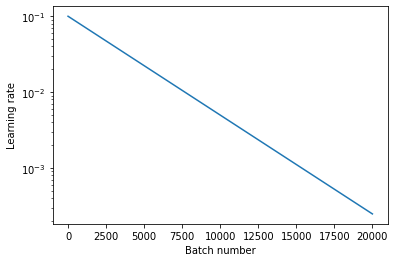

In [75]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9997     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [81]:
seed = 342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Toy data parameters ##########
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : False,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 5,
  'variable_length': False, # Takes max phrase length as phrase length
  'min_phrase_len': 10,
  'words': ['the', 'kinda0', 'kinda1', 'kinda2', 'kinda3', 'kinda4'],
  # 'corr_vals': {'01': 0.1,'12': 0.1,'23': 0.1, '30': 0.1},
}

# toy_params['words'] = ['kinda0', 'kinda1', 'kinda2']
# toy_params['words'] = generateWordBank(toy_params)
# toy_params['words'].append('kinda01')
# toy_params['words'].append('kinda12')
# toy_params['words'].append('kinda23')
# toy_params['words'].append('kinda03')
# toy_params['words'].remove('kinda0')
# toy_params['words'].remove('kinda1')
# toy_params['words'].append('bad0')
# toy_params['words'].append('bad1')
# toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

toy_params['base_word_vals'] = baseWordValues(toy_params)

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                               # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
  'input_size': len(toy_params['words']),           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(toy_params['sentiments']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 2e-4,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 1000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 7,                           # Number of new train sets to generate total (this is slow)
  'epochs': 2,                               # How many times to go through each train set completely
  'test_set_size': 200,

  'decay_fun': optimizers.exponential_decay(init_lr, decay_steps=1, decay_rate=decay_factor),
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
# Sets default parameters if they weren't set above
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('Total words:', len(toy_params['words']), 'Words:', toy_params['words'])
print('Total sentiments:', len(toy_params['sentiments']), 'Sentiments:', toy_params['sentiments'])

new_network = True
load_network = False
save_data = True

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_5classrgb_minimal_noRO_l2is2e-4_2.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

else:
  train_params['train_losses'] = []
  train_params['total_steps'] = 12000
  train_params['global_step'] = train_params['total_steps']

# Generate synthetic data and run training on said data
opt_state, train_params = train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs)

train_params.pop('decay_fun') # Can't pickle with decay fun
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
rnn_params, readout_params = final_params

Total words: 6 Words: ['the', 'kinda0', 'kinda1', 'kinda2', 'kinda3', 'kinda4']
Total sentiments: 5 Sentiments: ['sent0', 'sent1', 'sent2', 'sent3', 'sent4']
Sythentic data generated in: 36.49 sec.
Sythentic data generated in: 0.07 sec.
Running batches 0 to 1000
all logits shape (200, 50, 5)
masked logits shape (200, 1, 5)
Step 100 in 4.82 sec, step size: 0.09707, test acc 0.3100, avg training loss 1.6060
Step 200 in 1.90 sec, step size: 0.09420, test acc 0.3500, avg training loss 1.5666
Step 300 in 1.87 sec, step size: 0.09142, test acc 0.4650, avg training loss 1.4171
Step 400 in 1.87 sec, step size: 0.08872, test acc 0.7550, avg training loss 1.1798
Step 500 in 1.87 sec, step size: 0.08610, test acc 0.8450, avg training loss 0.6922
Step 600 in 1.87 sec, step size: 0.08355, test acc 0.8850, avg training loss 0.4829
Step 700 in 1.86 sec, step size: 0.08108, test acc 0.9300, avg training loss 0.3863
Step 800 in 1.91 sec, step size: 0.07868, test acc 0.9000, avg training loss 0.3933
Ste

In [ ]:
# Save the network
path =  '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3classrgb_xe_noRO_l2is2e-4.pickle'

# train_params.pop('decay_fun')

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

File already exists at: /content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3classrgb_xe_noRO_l2is2e-4.pickle


KeyboardInterrupt: ignored

In [76]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_6classrgb_minimal_noRO_l2is2e-4_2.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

Data Loaded


Text(0, 0.5, 'Train Loss')

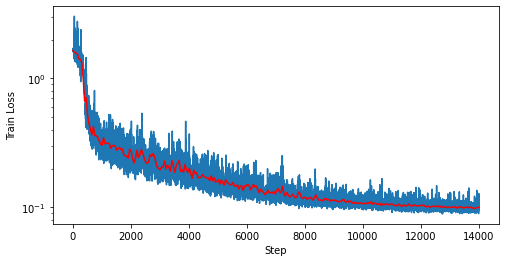

In [82]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]


plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [101]:
from scipy.spatial.distance import pdist, squareform

def build_cell(rnn_specs):
  if 'cell_type' not in rnn_specs: rnn_specs['cell_type']  = 'GRU' # Default
  
  print('Using {} cell'.format(rnn_specs['cell_type']))
  if rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.VanillaRNN(rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.GRU(rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.LSTM(rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.UGRNN(rnn_specs['hidden_size'])
  return cell

# Some helper functions to collect RNN hidden states.
@jax.jit
def _get_all_states(inputs, rnn_params):
  """Get RNN states in response to a batch of inputs (also returns masked states)."""
  initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])
  return renn.unroll_rnn(initial_states, inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch, rnn_params, only_final=False):
  """Return (masked) RNN states."""
  states = _get_all_states(batch['inputs'], rnn_params)
  if only_final: # returns only the final hidden state
    return [h[batch['index'][0]] for h in states]
  else:
    # return [h[:batch['index'][0]+1] for h in states]
    return [h[:idx[0]] for h, idx in zip(states, batch['index'])]

def keep_unique_fixed_points(fps, identical_tol=0.0, do_print=True):
  """Get unique fixed points by choosing a representative within tolerance.
  Args:
    fps: numpy array, FxN tensor of F fixed points of N dimension
    identical_tol: float, tolerance for determination of identical fixed points
    do_print: Print useful information? 
  Returns:
    2-tuple of UxN numpy array of U unique fixed points and the kept indices
  """
  keep_idxs = np.arange(fps.shape[0])
  if identical_tol <= 0.0:
    return fps, keep_idxs
  if fps.shape[0] <= 1:
    return fps, keep_idxs
  
  nfps = fps.shape[0]
  example_idxs = np.arange(nfps)
  all_drop_idxs = []

  # If point a and point b are within identical_tol of each other, and the
  # a is first in the list, we keep a.
  distances = squareform(pdist(fps, metric="euclidean"))
  for fidx in range(nfps-1):
    distances_f = distances[fidx, fidx+1:]
    drop_idxs = example_idxs[fidx+1:][distances_f <= identical_tol]
    all_drop_idxs += list(drop_idxs)
       
  unique_dropidxs = np.unique(all_drop_idxs)
  keep_idxs = np.setdiff1d(example_idxs, unique_dropidxs)
  if keep_idxs.shape[0] > 0:
    unique_fps = fps[keep_idxs, :]
  else:
    unique_fps = np.array([], dtype=np.int64)

  if do_print:
    print("    Kept %d/%d unique fixed points with uniqueness tolerance %f." %
          (unique_fps.shape[0], nfps, identical_tol))
    
  return unique_fps, keep_idxs

def participation_ratio_vector(C):
  """Computes the participation ratio of a vector of variances."""
  return np.sum(C) ** 2 / np.sum(C*C)

def find_m_k(k, dist_sq):
  """
  Calculates m_k from Levina, Bickel (Eq. (9))
  
  k: Number of nearest neighbors
  dist_sq: n x n matrix of Euclidean distances between points
  """

  n = dist_sq.shape[0]
  
  m_ks = np.zeros((n,))
  k_eff = k + 1 # Self-distance included, so bump k up by one

  for idx in range(n): # Calculate m_k(x) for all x
    idx_dists = dist_sq[idx, :]
    kidxs = np.argpartition(idx_dists, k_eff)
    max_kdist = np.max(idx_dists[kidxs[:k_eff]])
    sum_of_logs = 0
    for i in range(k_eff):
      if idx_dists[kidxs[i]] > 0: # Ignores self distance
        sum_of_logs += np.log(max_kdist / idx_dists[kidxs[i]])
    m_ks[idx] = 1 / (1/(k - 1) * sum_of_logs)

  return np.mean(m_ks)

import scipy
from scipy.spatial.distance import squareform

def find_correlation_dimension(r_val_range, dist_sq, num_pts=100, show_plot=False):
  """ 
  Calculates the linear regression fit of correlation dimension(r). The slope of said result is the estimated dimension

  r_val_range: log10(Range) of r values, specifically np.logspace(r[0], r[1]), 100)
  dist_sq: n x n matrix of Euclidean distances between points
  num_pts: number of points to fit

  Output: slope, intercept, r_value, p_value, std_err of linear regression fit
  """
  n = dist_sq.shape[0]
  distances = squareform(dist_sq)  # Changes to n * (n-1) / 2 vector
  r_values = np.logspace(r_val_range[0], r_val_range[1], num_pts)

  thresh_count = np.asarray([np.count_nonzero(distances < r_val) for r_val in r_values])
  c_n = 2/(n*(n - 1)) * thresh_count

  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(r_values), np.log10(c_n))

  if show_plot: # Shows plot of fit
    plt.figure()
    plt.loglog(r_values, c_n, 'b')

    y_fit_values = np.asarray([10**intercept * r_val**slope for r_val in r_values])
    plt.loglog(r_values, y_fit_values, 'r')

    plt.xlabel('r_value')
    plt.ylabel('C_n')

  return slope, intercept, r_value, p_value, std_err

In [83]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_trials = 1600

syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

hs = rnn_states(syn_data_test, rnn_params)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close
print(pts.shape)

if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T
print('Readout shape:', readout.shape)

Using GRU cell
Sythentic data generated in: 0.47 sec.
(39200, 128)
Readout shape: (5, 128)


Top 8 components: 0.9744915 ( [0.26523152 0.24197698 0.22064696 0.20136848 0.01283707 0.01248657
 0.01119871 0.00874521] )
Participation Ratio: 4.572114826667925
Copy this: PCA: [0.26523152 0.24197698 0.22064696 0.20136848 0.01283707 0.01248657
 0.01119871 0.00874521] PR: 4.572114826667925
Category 0 states: 397
Category 1 states: 340
Category 2 states: 326
Category 3 states: 280
Category 4 states: 257
Readout vec proj via PCA: [[ 3.7384903e+00 -3.4435587e+00 -8.5257119e-01 -5.7515335e-01
  -7.1998864e-02]
 [-1.2615234e+00 -2.3835864e+00  4.3741493e+00  1.7715758e-01
  -1.9760387e-01]
 [-8.1450063e-01 -1.3477669e+00 -1.2705698e+00  4.6071296e+00
  -6.1496973e-01]
 [-1.4169012e+00 -1.3108000e+00 -8.6634606e-01 -1.5642816e-01
   4.6234365e+00]
 [ 1.7819539e-02  6.8786941e-02 -5.9418779e-02  7.4757420e-02
   2.9319039e-01]
 [-1.7726888e-01 -6.0702529e-02  2.3362580e-01  2.1011028e-01
   2.2362477e-01]
 [-1.2323344e-02 -2.8799744e-02 -2.5139046e-01 -1.4338900e-03
  -1.7862003e-01]
 [-1.684

(128,)

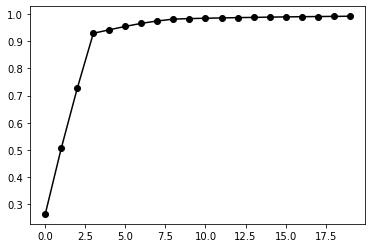

In [84]:
pc_dims = 8

# Finds percentage of variance explained by top pc_dims of PCA
pca_full = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_full.fit_transform(pts)
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_full.explained_variance_))
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# Group these states by the corresponding label.
states = []
for i in range(len(toy_params['sentiments'])):
  states.append([h for h, lbl in zip(hs, syn_data_test['labels']) if np.argmax(lbl[toy_params['phrase_length']-1]) == i])
  print('Category {} states:'.format(i), len(states[i]))

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(pts)
comp = pca.components_ # pc_dims x n_hidden
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
h0 = cell.get_initial_state(rnn_params)
h0.shape

Path label: [0. 1. 0.]
Path label: [1. 0. 0.]
Path label: [1. 0. 0.]


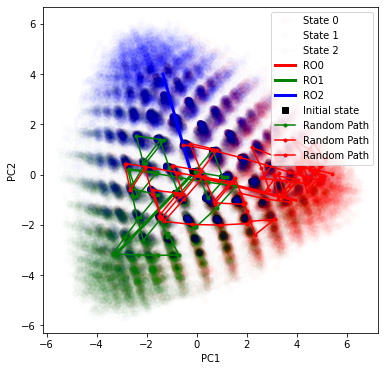

In [30]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'g', 'b', 'y', 'orange', 'm']
for i in range(len(toy_params['sentiments'])):
  if len(states[i]) > 0:
    pca_states = pca.transform(np.vstack(states[i])).T
    plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.01, label=state_labels[i])

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  # ro_dir = pca.transform(readout[i]).T #np.matmul(comp, readout[i])
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

path_idxs = [52, 454, 252]
for path_idx in path_idxs:
  path_pca = pca.transform(hs[path_idx]).T #np.matmul(comp, hs[path_idx].T)
  plt.plot(path_pca[pc1], path_pca[pc2], state_colors[np.argmax(syn_data_test['labels'][path_idx][27])], marker='.', label='Random Path')
  print('Path label:', syn_data_test['labels'][path_idx][27])

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

plt.legend()

#### Readout Vector Analysis

In [44]:
def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x 1 vector
  Finds the percentage of b's magnitude which lies in the subspace formed by the columns of A (its columnspace)
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T)
  b_proj = np.matmul(proj, b)

  return np.linalg.norm(b_proj)/np.linalg.norm(b)

# Percentage of readout vector mag in PCA dimensions

if rnn_specs['ro_bias']:
  wO, bO = readout_params
else:
  wO = readout_params
readout = wO.T

readout_mags = []
readout_pca_mags = []
pc_dims = 3
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

print('Theoretical angle:', 180/np.pi * np.arccos(-1/(toy_params['n_unordered']-1)))

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j])))

indices = [i for i in range(len(readout))]
for i in range(len(readout)):
  A = []
  for j in range(len(readout)):
    if i != j:
      A.append(readout[j])
  print('Perc of {} in rest:'.format(i), subspace_perc(np.asarray(A).T, readout[i]))

Readout 0 mag: 4.8841715
Readout 0 (perc in first 3 PC dims): 0.8079809
Readout 1 mag: 4.9270496
Readout 1 (perc in first 3 PC dims): 0.947746
Readout 2 mag: 4.877336
Readout 2 (perc in first 3 PC dims): 0.76641583
Readout 3 mag: 4.7508707
Readout 3 (perc in first 3 PC dims): 0.4189801
Readout 4 mag: 4.8002224
Readout 4 (perc in first 3 PC dims): 0.23083876
Readout 5 mag: 4.757399
Readout 5 (perc in first 3 PC dims): 0.5973426
Readout 6 mag: 4.664847
Readout 6 (perc in first 3 PC dims): 0.7462872
Theoretical angle: 99.59406822686046
Angle (1, 0): 99.9969474114648
Angle (2, 0): 99.4290035215999
Angle (2, 1): 97.66184916821001
Angle (3, 0): 98.48966126542639
Angle (3, 1): 99.71087859845716
Angle (3, 2): 100.88563015456432
Angle (4, 0): 101.75203282059128
Angle (4, 1): 100.0665060579722
Angle (4, 2): 101.07523620592389
Angle (4, 3): 97.06090863446478
Angle (5, 0): 99.96357510718012
Angle (5, 1): 99.11416595180816
Angle (5, 2): 99.34452774194519
Angle (5, 3): 99.4615971843192
Angle (5, 4):

In [ ]:
# Exact symplex numbers

simplex = []
simplex.append(np.asarray([1,0,0]))
simplex.append(np.asarray([-1/3, np.sqrt(8)/3, 0]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, np.sqrt(2/3)]))
simplex.append(np.asarray([-1/3, -np.sqrt(2)/3, -np.sqrt(2/3)]))

read_out_mags = []
for i in range(len(simplex)):
  read_out_mags.append(np.linalg.norm(simplex[i]))

print(read_out_mags)

for i in range(len(simplex)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(simplex[i], simplex[j])/(read_out_mags[i]*read_out_mags[j])))

A01 = np.array([simplex[0], simplex[1]]).T
A02 = np.array([simplex[0], simplex[2]]).T
A12 = np.array([simplex[1], simplex[2]]).T

print('Perc of 2 in (0,1):', subspace_perc(A01, simplex[2]))
print('Perc of 1 in (0,2):', subspace_perc(A02, simplex[1]))
print('Perc of 0 in (1,2):', subspace_perc(A12, simplex[0]))

[1.0, 1.0, 1.0, 1.0]
Angle (1, 0): 109.47122063449069
Angle (2, 0): 109.47122063449069
Angle (2, 1): 109.47122063449069
Angle (3, 0): 109.47122063449069
Angle (3, 1): 109.47122063449069
Angle (3, 2): 109.47122063449069


NameError: ignored

### Find Fixed Points

In [18]:
word = None
if word == None:
  word_tensor = jnp.zeros(rnn_specs['input_size'])
  # word_tensor = 1/4*jnp.ones(rnn_specs['input_size'])
else:
  word_tensor = wordToTensor(word, toy_params['words'])[0]

xstar = jnp.zeros((pts.shape[0], rnn_specs['input_size']))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-3, num_steps=10000)
print('Done')

  2%|▏         | 172/10000 [00:01<01:19, 123.46it/s]


Done


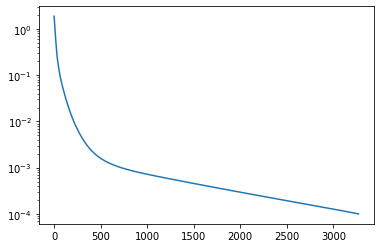

In [ ]:
plt.semilogy(loss_hist)

Text(0, 0.5, 'PC2')

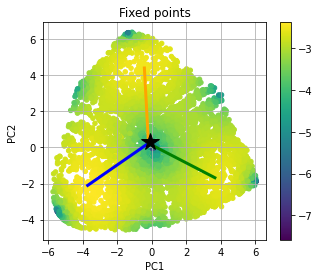

In [19]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
ro_colors = ['g', 'b', 'orange', 'm', 'r']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((128,)))).T
for i in range(len(readout)):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, ro_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

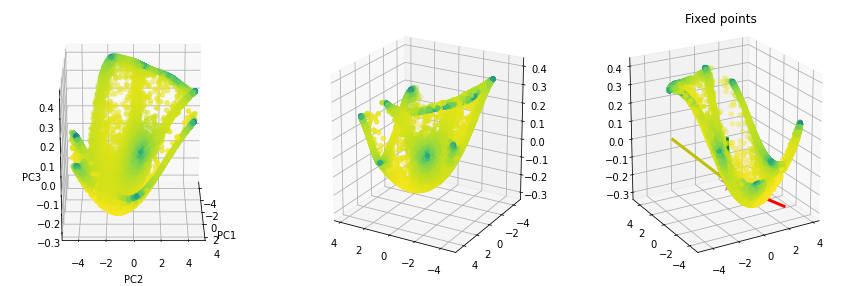

In [ ]:
# triangulate in the underlying parametrization
from matplotlib.tri import Triangulation

pc1 = 0
pc2 = 1
pc3 = 2

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection='3d');
ax2 = fig.add_subplot(132, projection='3d');
ax3 = fig.add_subplot(133, projection='3d');


pca_fps = pca.transform(np.vstack(fixed_points)).T
# max_loss = np.max(np.log10(fp_losses))
# min_loss = np.min(np.log10(fp_losses))
# loss_range = max_loss - min_loss
# colors = []
# for loss in fp_losses:
#   seq_color_norm = (np.log10(loss)-min_loss)/loss_range
#   colors.append((seq_color_norm, 0, 1 - seq_color_norm, 1.0))
# ax.plot_trisurf(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], edgecolor='none', color='grey')
ax.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))
ax2.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))
ax3.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))

# Plots readout direction
ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [pca_h0[pc1], ro_dir[pc1]]
  y_ro = [pca_h0[pc2], ro_dir[pc2]]
  z_ro = [pca_h0[pc3], ro_dir[pc3]]
  plt.plot(x_ro, y_ro, z_ro, ro_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
plt.title('Fixed points')

# pca_word = 3*word_deflection('very1', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 3*word_deflection('very0', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

ax.set_xlabel('PC'+str(pc1+1))
ax.set_ylabel('PC'+str(pc2+1))
ax.set_zlabel('PC'+str(pc3+1))

# Azimuthal angle and rotation
ax.view_init(20, 0)
ax2.view_init(20, 120)
ax3.view_init(20, 240)

#### Single Fixed Point Analysis

Text(0, 0.5, 'PC2')

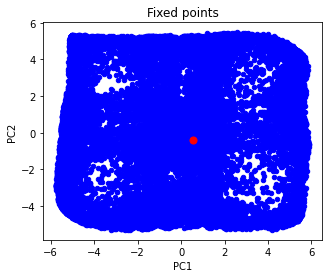

In [ ]:
# Pick a fixed point.
# fp_idx = np.argmin(fp_losses)
fp_idx = 350
fp = fixed_points[fp_idx]

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')
plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='r')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
# Computes the recurrent Jacobian.
jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))

# Perform an eigendecomposition to get eigenvectors and eigenvalues.
R, E, L = renn.eigsorted(jac)

Text(0, 0.5, 'imag')

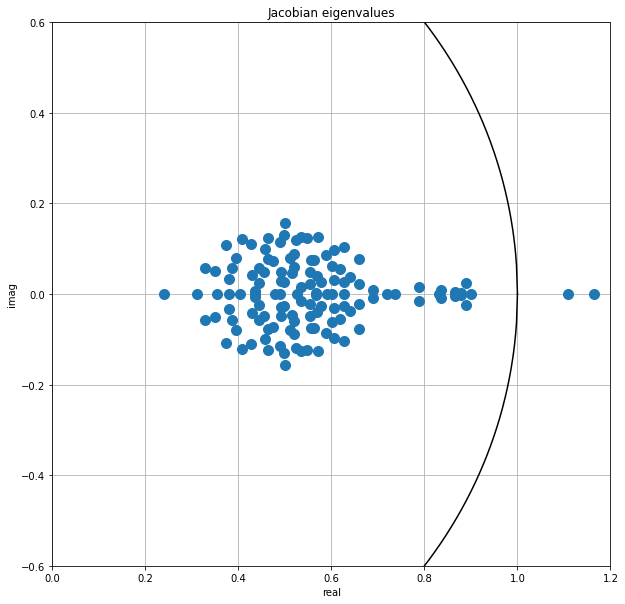

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.real(E), np.imag(E), 'o', ms=10)
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.6, 0.6)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')

plt.title('Jacobian eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

#### Fixed Point Grid Search

Mean distance: 1.1019021130652566
Treshold conversion: 4.85675306711071


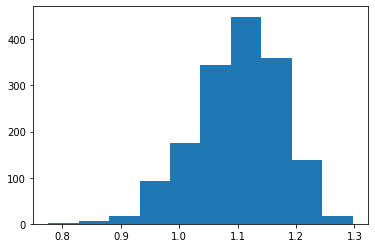

In [37]:
# Average distance traveled
avg_step_sizes = np.zeros((len(hs),))
for hs_idx in range(len(hs)):
  hs_h0 = np.concatenate([hs[hs_idx], h0[np.newaxis, :]], axis=0)
  total_dist = 0
  for time_idx in range(hs_h0.shape[0] - 1):
    total_dist += np.sqrt(np.sum((hs_h0[time_idx+1] - hs_h0[time_idx])**2))
  avg_step_sizes[hs_idx] = total_dist/hs[hs_idx].shape[0]

print('Mean distance:', np.mean(avg_step_sizes))
print('Treshold conversion:', (2*np.mean(avg_step_sizes))**2)

# Histogram of mean distance
plt.hist(avg_step_sizes, bins=10)
plt.show()

In [39]:
pca_full = PCA(n_components=rnn_specs['hidden_size'])
pts_pca = pca_full.fit_transform(pts)
pr_hs = participation_ratio_vector(pca_full.explained_variance_)
print('Participation Ratio of Hidden States:', pr_hs)

grid_dims = np.int(np.ceil(pr_hs))
print("Grid over first {} PC dimensions".format(grid_dims))

range_extend_ratio = 1 # Amount to extend total range
max_points = 100 # Maximum points along biggest dimension
grid_coords = []
spacing = 0

for dim_idx in range(grid_dims):
  max_co = np.max(pts_pca[:,dim_idx])
  min_co = np.min(pts_pca[:,dim_idx])
  range_co = np.copy(max_co - min_co)

  max_co += range_extend_ratio/2 * range_co # Extend range
  min_co -= range_extend_ratio/2 * range_co

  if dim_idx == 0:
    spacing = (max_co - min_co)/max_points                                    

  grid_coords.append(np.linspace(min_co, max_co, num=np.int(np.ceil((max_co - min_co)/spacing))))
  print('In PC{} dim, using {} points'.format(dim_idx, np.int(np.ceil((max_co - min_co)/spacing))))

# Creates grid and turns them into PCA points
grid_vals = np.asarray(np.meshgrid(*grid_coords))
grid_vals_flat = grid_vals.reshape(grid_vals.shape[0], np.prod(grid_vals.shape[1:]))
print('Total hidden states:',  np.prod(grid_vals.shape[1:]))
pca_points = np.zeros((grid_vals_flat.shape[1], rnn_specs['hidden_size']))
pca_points[:, :grid_dims] = grid_vals_flat.T

# Transform back into hidden state space
hs_grid_points =  jnp.asarray(pca_full.inverse_transform(pca_points))
print('Hs grid points shape', hs_grid_points.shape)

# Fixed point state search
word_tensor = jnp.zeros(rnn_specs['input_size'])

hs_ones = jnp.ones((hs_grid_points.shape[0],))
xstar = jnp.outer(hs_ones, jnp.asarray(word_tensor))

fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
fp_losses = fp_loss_fun(hs_grid_points, xstar)

Participation Ratio of Hidden States: 2.288684736506615
Grid over first 3 PC dimensions
In PC0 dim, using 100 points
In PC1 dim, using 97 points
In PC2 dim, using 29 points
Total hidden states: 281300
Hs grid points shape (281300, 128)


In [55]:
thresh = 0.048
hs_grid_thresh = hs_grid_points[fp_losses < thresh]
fp_losses_thresh = fp_losses[fp_losses < thresh]
print('Number of points', hs_grid_thresh.shape[0])

k_val = 100
r_range = (-0.5, 0)

pca_fps = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fps.fit_transform(hs_grid_thresh)
explained_var = pca_fps.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_fps.explained_variance_))

distances = pdist(hs_grid_thresh, metric="euclidean") # n_fp * (n_fps-1) / 2
dist_sq = squareform(distances) # n_fp x n_fp 

print('m_k Value:', find_m_k(k_val, dist_sq))
corr_dim, _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=False)
print('Correlation Dimension:', corr_dim)

Number of points 2097
Top 5 components: 0.99999994 ( [6.1929125e-01 3.7306112e-01 7.6475996e-03 1.0453837e-13 6.9182644e-15] )
Participation Ratio: 1.9129430896733104
m_k Value: 2.516659574061362
Correlation Dimension: 2.6180110933002236


Number of points 8630
Number of points 6724
Number of points 5104
Number of points 3480
Number of points 2097


Text(0, 0.5, 'Dimensionality Measure')

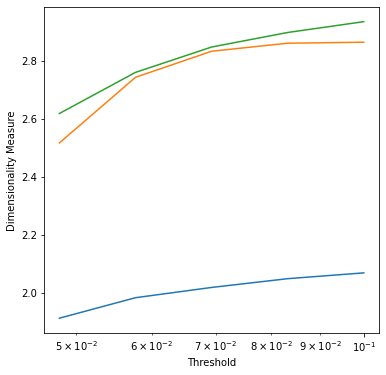

In [54]:
num_pts = 5
thresh_vals = np.logspace(-1, np.log10(0.048), num_pts)

pr_vals = np.zeros((num_pts,))
k_val = 100
m_k_vals = np.zeros((num_pts,))
r_range = (-0.5, 0)
corr_dim_vals = np.zeros((num_pts,))

for thresh_idx in range(len(thresh_vals)):
  hs_grid_thresh = hs_grid_points[fp_losses < thresh_vals[thresh_idx]]
  print('Number of points', hs_grid_thresh.shape[0])
  pca_fps = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_fps.fit_transform(hs_grid_thresh)
  pr_vals[thresh_idx] = participation_ratio_vector(pca_fps.explained_variance_)

  distances = pdist(hs_grid_thresh, metric="euclidean") # n_fp * (n_fps-1) / 2
  dist_sq = squareform(distances) # n_fp x n_fp 

  m_k_vals[thresh_idx] = find_m_k(k_val, dist_sq)
  corr_dim_vals[thresh_idx], _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=False)

plt.figure(figsize=(6, 6))
plt.semilogx(thresh_vals, pr_vals, label='Participation ratio')
plt.semilogx(thresh_vals, m_k_vals, label='m_k for k='+str(k_val))
plt.semilogx(thresh_vals, corr_dim_vals, label='Correlation Dimension')
plt.xlabel('Threshold')
plt.ylabel('Dimensionality Measure')

In [50]:
corr_dim_vals

array([nan, nan])

#### Many Fixed Point Analysis

In [ ]:
# Jacobian projections
def word_deflection(word, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns (linearized) deflection of word from hs in terms of pcs of comp""" 
  word_tensor = wordToTensor(word, toy_params['words'])
  input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs)
  hidden_update = np.matmul(input_jac, word_tensor[0])
  
  return np.matmul(comp, hidden_update)

def hs_modes(n_eigs, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns deflection of top n_eigs eigenvalues from hs in terms of pcs of comp""" 
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs))
  R, E, L = renn.eigsorted(jac)

  print('HS top eigenvalues:', E[:n_eigs+1])

  return np.matmul(comp, R[:, :n_eigs]).T

In [ ]:
# Plots Jacobian eigenvalues as a function of fixed point

pca_fps = pca.transform(np.vstack(fixed_points)).T

# Sorts fixed points by pc dimension
# sort_idxs = np.argsort(pca_fps[0])
# sorted_pca_fps = pca_fps[0][sort_idxs]
# sorted_fp = fixed_points[sort_idxs]

# Sorts fixed points by distance from mean fixed point
fp_mean = np.mean(fixed_points, axis=0)
fp_dist = np.zeros((fixed_points.shape[0],))
for fp_idx in range(fixed_points.shape[0]):
  fp_dist[fp_idx] = np.linalg.norm(fixed_points[fp_idx]-fp_mean, ord=1)
sort_idxs = np.argsort(fp_dist)
sorted_fpidx = fp_dist[sort_idxs]
sorted_fp = fixed_points[sort_idxs]


take_every = 25
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals = np.zeros((int(n_fp/take_every), n_top))
max_evals_im = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = sorted_fp[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))
  _, E, _ = renn.eigsorted(jac)
  rE = np.real(E)
  iE = np.imag(E)
  rE.sort()
  iE.sort()
  pc_dim_val[i] = sorted_fpidx[i*take_every]
  max_evals[i] = rE[-n_top:]
  max_evals_im[i] = iE[-n_top:]

Evaluating 10000 fixed points.


Text(0, 0.5, 'Top Im(Eigenvalues)')

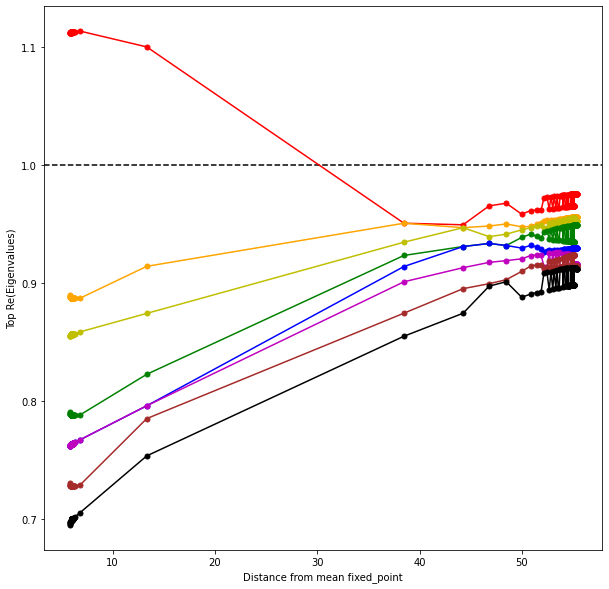

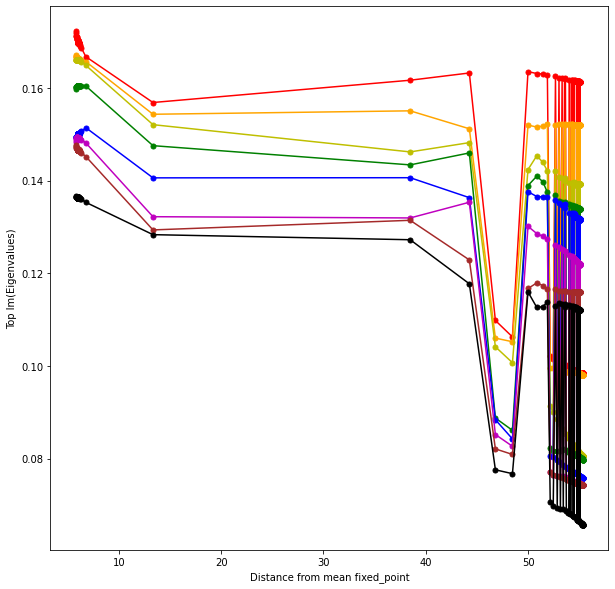

In [ ]:
plt.figure(figsize=(10,10))
plt.axhline(1.0, c='k', linestyle='--')
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Re(Eigenvalues)')

plt.figure(figsize=(10,10))
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals_im[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Im(Eigenvalues)')

In [ ]:
print('Number of fixed points:', len(fixed_points))

Number of fixed points: 25000


HS top eigenvalues: [0.8956536+0.j 0.8526117+0.j 0.8031965+0.j]
HS top eigenvalues: [0.89565367+0.j 0.8526116 +0.j 0.8031965 +0.j]
HS top eigenvalues: [1.1041673 +0.j 0.86134094+0.j 0.8294861 +0.j]
HS top eigenvalues: [1.1124028 +0.j 0.8614164 +0.j 0.81864643+0.j]
HS top eigenvalues: [1.0988455 +0.j 0.85771126+0.j 0.8039921 +0.j]


Text(0, 0.5, 'PC2')

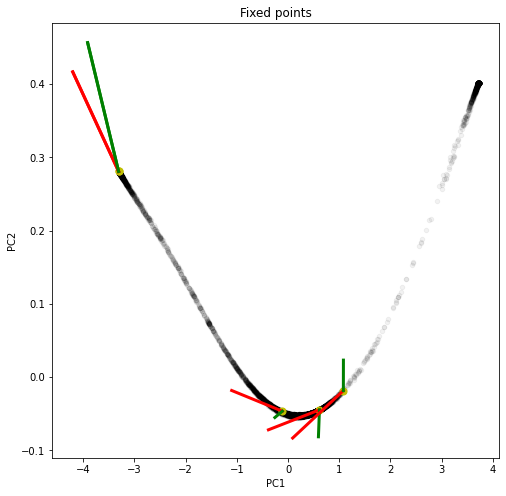

In [ ]:
# Zero modes
fp_idxs =[600, 1000, 4000, 22000, 24000]
num_eigs = 2
scale = 1 # Amount to scale up eigenvalues

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1
plt.figure(figsize=(8, 8))

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[pc1])
sorted_fp = fixed_points[sort_idxs]

pca_fps = pca.transform(np.vstack(sorted_fp)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], alpha=0.05, s=20, c='k')

eig_colors = ['r', 'g', 'm', 'b', 'orange', 'grey']
for fp_idx in fp_idxs:
  mode_proj = scale * np.real(hs_modes(num_eigs, cell, toy_params, rnn_params, rnn_specs, sorted_fp[fp_idx], comp))
  for i in range(num_eigs):
    plt.plot(pca_fps[pc1][fp_idx] + [0, mode_proj[i][pc1]], pca_fps[pc2][fp_idx] + [0, mode_proj[i][pc2]], eig_colors[i], linewidth=3)
  plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='y')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
word_tensor = wordToTensor('not', toy_params['words'])

# Finds deflection of RNNs for a given input
ref_idx = 400
ref_fp = fixed_points[ref_idx]
def_state = cell.apply(rnn_params, word_tensor[0], ref_fp)
delta_hnot_ref = def_state - ref_fp
delta_hnot_ref_mag = np.linalg.norm(delta_hnot_ref)

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[0])
sorted_pca_fps = pca_fps[0][sort_idxs]
sorted_fp = fixed_points[sort_idxs]

take_every = 10
n_fp = len(fixed_points)
n_eval = int(n_fp/take_every)

def_state = np.zeros((n_eval, rnn_specs['hidden_size']))
delta_hnot = np.zeros((n_eval, rnn_specs['hidden_size']))
hnot_angles = np.zeros((n_eval,))
hnot_mags = np.zeros((n_eval,))
pc_dim_val = np.zeros((n_eval,))
for i in tqdm(range(0, n_eval)):
  def_state[i] = cell.apply(rnn_params, word_tensor[0], sorted_fp[i*take_every])
  delta_hnot[i] = def_state[i] - sorted_fp[i*take_every]
  pc_dim_val[i] = sorted_pca_fps[i*take_every]
  hnot_mags[i] = np.linalg.norm(delta_hnot[i])
  hnot_angles[i] = 180/np.pi * np.arccos(np.dot(delta_hnot[i], delta_hnot_ref)/(hnot_mags[i]*delta_hnot_ref_mag))

delta_hnot_mean = np.mean(delta_hnot)
hnot_perc_diff = np.zeros((n_eval,))
for i in range(0, n_eval):
  mean_diff = delta_hnot[i] - delta_hnot_mean
  hnot_perc_diff[i] = np.linalg.norm(mean_diff)/hnot_mags[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in arccos


Text(0, 0.5, 'Perc diff from mean')

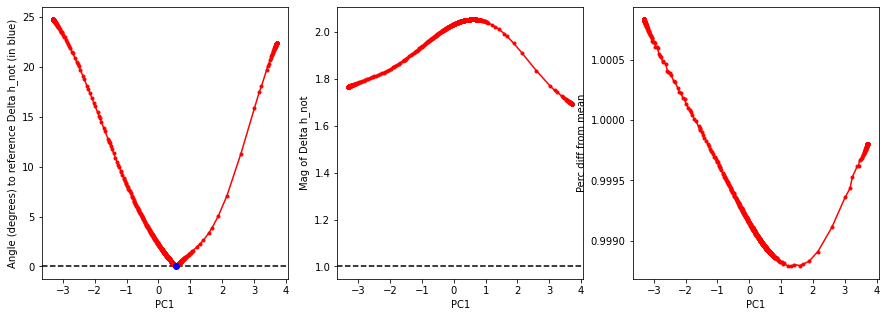

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot('131')
ax1.axhline(0.0, c='k', linestyle='--')
ax1.plot(pc_dim_val, hnot_angles, 'r-', marker='.')
ax1.plot(pca_fps[0][ref_idx], [0.0], 'b-o')

ax1.set_xlabel('PC1')
ax1.set_ylabel('Angle (degrees) to reference Delta h_not (in blue)')

ax2 = plt.subplot('132')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.plot(pc_dim_val, hnot_mags, 'r-', marker='.')

ax2.set_xlabel('PC1')
ax2.set_ylabel('Mag of Delta h_not')

ax3 = plt.subplot('133')
ax3.plot(pc_dim_val, hnot_perc_diff, 'r-', marker='.')

ax3.set_xlabel('PC1')
ax3.set_ylabel('Perc diff from mean')

Text(0, 0.5, 'PC2')

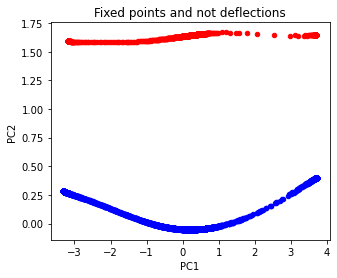

In [ ]:
# Plots fixed points and deflected states

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')

pca_defs = pca.transform(np.vstack(def_state)).T
plt.scatter(pca_defs[pc1], pca_defs[pc2], s=20, c='r')

plt.title('Fixed points and not deflections')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

#### Readout Space Projection

x 0.9999999
y 0.99999994
x.y -5.5879354e-08


(-7.0, 7.0)

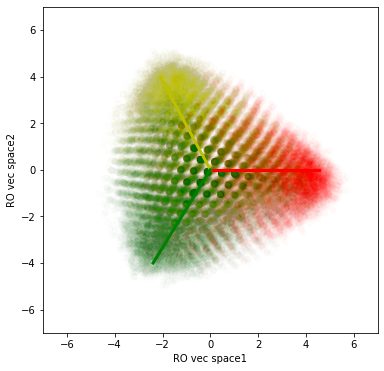

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  x_vals = np.dot(np.matmul(np.vstack(states[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(states[i]), proj), y_basis)
  plt.plot(x_vals, y_vals, state_colors[i]+'o', alpha=0.01, label=state_labels[i])

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

x 0.9999999
y 0.99999994
x.y -5.5879354e-08


(-7.0, 7.0)

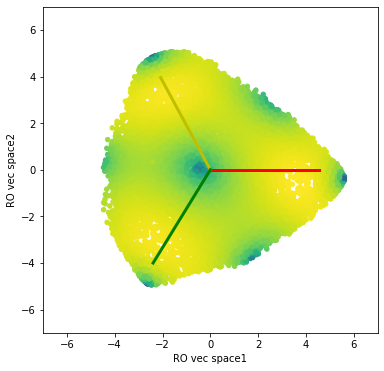

In [ ]:
# Project fixed points onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# Fixed points
x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(x_vals, y_vals, s=20, c=np.log10(fp_losses))
plt.colorbar

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

### FP Manifold Dimension


In [21]:
unique_tol = 0.025
do_print = True
fps_reduced, unique_kidxs = keep_unique_fixed_points(fixed_points, unique_tol, do_print)
# fps_reduced = fixed_points
n_fp = fps_reduced.shape[0]

time1 = time.time()
distances = pdist(fps_reduced, metric="euclidean") # n_fp * (n_fps-1) / 2
dist_sq = squareform(distances) # n_fp x n_fp 
print('Scipy Eucl Dist Time: {:0.2f} sec.'.format(time.time() - time1))
distances.sort()
print('Min dist:', distances[0])
print('Max dist:', distances[-1])

pca_fps = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fps.fit_transform(fps_reduced)
explained_var = pca_fps.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_fps.explained_variance_))

    Kept 7815/9800 unique fixed points with uniqueness tolerance 0.025000.
Scipy Eucl Dist Time: 3.11 sec.
Min dist: 0.02503001468190767
Max dist: 11.980997102483087
Top 5 components: 0.9884731 ( [0.5078273  0.44932327 0.01598972 0.00877265 0.00656014] )
Participation Ratio: 2.1730449810550305


In [22]:
# k_vals = np.asarray([int(k_val) for k_val in range(50,80)])
# m_k_means = []
# for k_val in k_vals:
#   m_ks = np.zeros((n_fp,))
#   for i in range(n_fp):
#     m_ks[i] = find_m_k(i, k_val, dist_sq)
#   m_k_means.append(np.mean(m_ks))

k_val = 200
m_k_val = find_m_k(k_val, dist_sq)
print('m_k average:', m_k_val)

m_k average: 1.9381394918848196


k_avged Estimate: 2.033284748961476


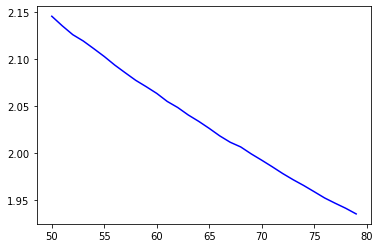

In [ ]:
print('k_avged Estimate:', 1/(np.max(k_vals)-np.min(k_vals)+1)*np.sum(m_k_means))

plt.figure()
plt.plot(k_vals, m_k_means, 'b')

Slope: 1.8308126409600063


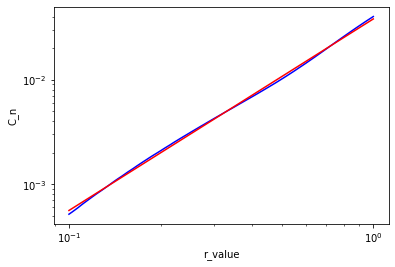

In [23]:
# r_range = (np.log10(1.1*distances[0]),np.log10(distances[-1])z)
r_range = (-1, 0)
slope, _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=True)
print('Slope:', slope)

### Training Paths

#### Rotation/Reflection

In [ ]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_trials = 400

syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

hs = rnn_states(syn_data_test, rnn_params)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

pca_full = PCA(n_components=rnn_specs['hidden_size']).fit(pts)
comp = pca_full.components_ # pc_dims x n_hidden

pc_dims = 2

syn_data_path = generate_data(1, toy_params, rnn_specs['output_size'])
hs_path = rnn_states(syn_data_path, rnn_params)[0]
pca_path = np.matmul(hs_path, comp.T) # length x pc_dims

print(syn_data_path['inputs'][0][:5])
print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:5])
path_label = np.argmax(syn_data_path['labels'][0, toy_params['phrase_length']-1])

# # Finds percent of hidden states magnitude explained in first few PCA dimensions
# pca_dims = 3
# perc_mag_hs = np.zeros((hs_path.shape[0],))
# for i in range(hs_path.shape[0]):
#   perc_mag_hs[i] = np.linalg.norm(pca_path[i,:pca_dims])/np.linalg.norm(hs_path[i])

# plt.figure(figsize=(6, 6))
# plt.plot(perc_mag_hs)

rot_label = (path_label + 1) % len(toy_params['sentiments'])
print('Path label: {}, Rotating To: {}'.format(path_label, rot_label))

angle = np.arccos(np.dot(readout[path_label], readout[rot_label])/(np.linalg.norm(readout[path_label])*np.linalg.norm(readout[rot_label])))
rot_matrix = np.identity(hs_path.shape[-1])
rot_matrix[0,0] = np.cos(angle)
rot_matrix[0,1] = np.sin(angle)
rot_matrix[1,0] = -1 * np.sin(angle)
rot_matrix[1,1] = np.cos(angle)
rot_pca_path = np.matmul(pca_path, rot_matrix.T)

comp_inv = np.linalg.inv(comp)
rot_path = np.matmul(rot_pca_path, comp_inv.T)

Using GRU cell
Sythentic data generated in: 0.17 sec.
Sythentic data generated in: 0.00 sec.
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
['kinda2', 'very1', 'the', 'very2', 'the']
Path label: 2, Rotating To: 0


In [ ]:
def pathToPhrase(path_of_hs):
  hs_path_winit = np.concatenate((h0[np.newaxis, :], path_of_hs), axis=0)
  words = []

  for time_idx in range(path_of_hs.shape[0]):
    path_diff = hs_path_winit[time_idx+1] - hs_path_winit[time_idx]
    n_words = len(toy_params['words'])
    word_defs = np.zeros((n_words, hs_path_winit.shape[-1]))
    word_diffs = np.zeros((n_words,))
    input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs_path_winit[time_idx])
    
    for i in range(n_words): # Iterates over all words
      word_tensor = wordToTensor(toy_params['words'][i], toy_params['words'])
      word_defs[i] = np.matmul(input_jac, word_tensor[0])
      word_diffs[i] = np.linalg.norm(word_defs[i] - path_diff)
    words.append(toy_params['words'][np.argmin(word_diffs)])

  return words

rot_phrase_words = pathToPhrase(rot_path)

print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:20])
print(rot_phrase_words[:20])

['kinda2', 'very1', 'the', 'very2', 'the', 'kinda2', 'kinda0', 'kinda2', 'the', 'very2', 'kinda0', 'kinda1', 'very2', 'kinda1', 'very2', 'very2', 'the', 'very1', 'very1', 'very0']
['kinda0', 'very2', 'the', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda2', 'kinda0', 'kinda2', 'kinda0', 'kinda0', 'the', 'very2', 'kinda2', 'kinda0']


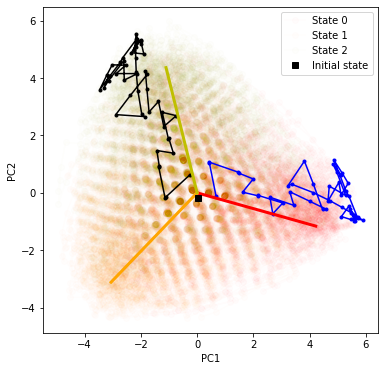

In [ ]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  pca_states = pca_full.transform(np.vstack(states[i])).T
  plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.01, label=state_labels[i])

plt.plot(pca_path[:,pc1], pca_path[:,pc2], c='k', marker='.')
plt.plot(rot_pca_path[:,pc1], rot_pca_path[:,pc2], c='b', marker='.')

# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

plt.legend()

#### Network Flow

In [ ]:
# Shows flow of network at various locations in hidden-state space
pc_dims = 5

flow_points_raw = fixed_points
# flow_points_raw = pts
word = 'very0' #None
if word == None:
  word_tensor = jnp.zeros(rnn_specs['input_size'])
else:
  word_tensor = wordToTensor(word, toy_params['words'])[0]

# word_tensor = np.asarray([wordToTensor('not', toy_params['words'])[0], wordToTensor('very0', toy_params['words'])[0]])

# Filters out non-unique points
unique_tol = 0.25
do_print = True
points_unique, unique_kidxs = keep_unique_fixed_points(flow_points_raw, unique_tol, do_print)
steps = 1

points_reduced = points_unique #[::18]
points_final_pca = np.zeros((len(points_reduced), pc_dims))
# print(points_reduced.shape)
points_init_pca = pca.transform(np.vstack(points_reduced))
for pt_idx in range(len(points_reduced)):
  # print(points_reduced[pt_idx].shape)
  # points_init_pca[pt_idx] = np.matmul(comp, points_reduced[pt_idx])
  ref_point = points_reduced[pt_idx]
  for step in range(steps):
    def_state = cell.apply(rnn_params, word_tensor, ref_point)
    ref_point = def_state
  points_final_pca[pt_idx] = pca.transform(np.atleast_2d(def_state))[0]
  # points_final_pca[pt_idx] = np.matmul(comp, def_state)

print(points_init_pca.shape)
print(points_final_pca.shape)

    Kept 461/22777 unique fixed points with uniqueness tolerance 0.250000.
(461, 5)
(461, 5)


Text(0, 0.5, 'PC2')

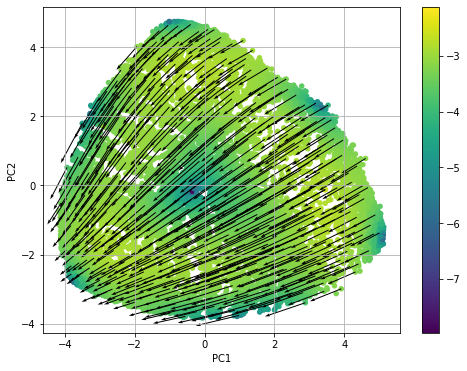

In [ ]:
plt.figure(figsize=(8, 6))

pc1 = 0
pc2 = 1

pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
plt.grid()

plt.colorbar()

plt.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], points_final_pca[:,pc1]-points_init_pca[:,pc1], 
           points_final_pca[:,pc2]-points_init_pca[:,pc2], scale=1, units='xy')

# pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

1.8042524650697227
0.3898221031795444


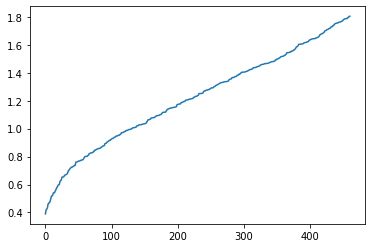

In [ ]:
pc1 = 0
pc2 = 1

deflection_mags = np.zeros((points_init_pca.shape[0]))
counter = 0
for fp_init, fp_final, idx in zip(points_init_pca, points_final_pca, range(points_init_pca.shape[0])):
  deflection = np.asarray([fp_final[pc1] - fp_init[pc1], fp_final[pc2] - fp_init[pc2]])
  deflection_mags[idx] = np.linalg.norm(deflection)

print(np.max(deflection_mags))
print(np.min(deflection_mags))
deflection_mags.sort()

plt.plot(deflection_mags)

In [ ]:
print(np.max(deflection_mags))
print(np.min(deflection_mags))

1.8124122808769607
0.4469337217440654


# Training Analysis

In [ ]:
def pca_analysis(opt_state, toy_params, rnn_specs):
  cell = build_cell(rnn_specs)

  n_trials = 1000 # Number of phrases to gather hidden states from
  rnn_params, readout_params = get_params(opt_state)

  syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

  hs = rnn_states(syn_data_test, rnn_params)
  pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

  if rnn_specs['ro_bias']:
    wO, bO = readout_params
  else:
    wO = readout_params
  readout_vecs = wO.T

  # Finds percentage of variance explained by top pc_dims of PCA
  pca_full = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_full.fit_transform(pts)
  explained_var = pca_full.explained_variance_ratio_

  return explained_var, readout_vecs

In [ ]:
seed = 342343
print("Seed: %d" % seed)
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

########## Toy data parameters ##########
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : True,
  'variable_length': False, # Takes max phrase length as phrase length
  'min_phrase_len': 10,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 3,
}

# toy_params['words'] = ['the', 'kinda1100', 'kinda0011', 'kinda1010', 'kinda0101']
toy_params['words'] = generateWordBank(toy_params)
# toy_params['sentiments'] = ['One', 'Two', 'Three', 'Four', 'Five']
# toy_params['words'].append('kinda01')
# toy_params['words'].append('kinda01')
# toy_params['words'].remove('kinda0')
# toy_params['words'].remove('kinda1')
# toy_params['words'].remove('very0')
# toy_params['words'].remove('very1')
# toy_params['words'].remove('very2')
# toy_params['words'].remove('very3')
# toy_params['words'].remove('very4')
# toy_params['words'].append('bad0')
# toy_params['words'].append('bad1')
# toy_params['sentiments'] = ['Red', 'Green', 'Blue']
# toy_params['sentiments'] = ['Bad', 'Neutral', 'Good']
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'LSTM',                               # Supports 'GRU' or 'LSTM'
  'input_size': len(toy_params['words']),           # Number of inputs to the RNN
  'hidden_size': 128,                               # Number of units in the RNN
  'output_size': len(toy_params['sentiments']),     # Number of outputs in the RNN
  'ro_bias': False,                                 # Include a bias with the readout
  'ro_simplex_init': False,
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 2e-5,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 100,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 1,                           # Number of new train sets to generate total (this is slow)
  'epochs': 1,                               # How many times to go through each train set completely
  'test_set_size': 200,

  'decay_fun': optimizers.exponential_decay(init_lr, decay_steps=1, decay_rate=decay_factor),
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] # Number of examples in train set

Seed: 342343


In [ ]:
num_checkpoints = 100

########## Run ##########

print('Total words:', len(toy_params['words']), 'Words:', toy_params['words'])
print('Total sentiments:', len(toy_params['sentiments']), 'Sentiments:', toy_params['sentiments'])

new_network = True
load_network = False
save_data = False

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/gru_2x2class_xe_noRO.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
  output_shape, initial_params = init_fun(prng_key, input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['sentiments']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

explained_var = np.zeros((num_checkpoints, rnn_specs['hidden_size']))
if rnn_specs['cell_type'] == 'Vanilla' or rnn_specs['cell_type'] == 'GRU' or rnn_specs['cell_type'] == 'UGRNN' :
  readout_cps = np.zeros((num_checkpoints, rnn_specs['output_size'], rnn_specs['hidden_size']))
elif rnn_specs['cell_type'] == 'LSTM':
  readout_cps = np.zeros((num_checkpoints, rnn_specs['output_size'], 2*rnn_specs['hidden_size']))
checkpoint_batches = np.zeros((num_checkpoints,))

for cp in range(num_checkpoints):
  # Calculates before train, so checkpoint 0 is initial data
  explained_var[cp], readout_cps[cp] = pca_analysis(opt_state, toy_params, rnn_specs)
  checkpoint_batches[cp] = train_params['global_step']

  # Generate synthetic data and run training on said data
  opt_state, train_params = train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs)

Total words: 9 Words: ['kinda0', 'very0', 'kinda1', 'very1', 'kinda2', 'very2', 'the', 'not', 'extremely']
Total sentiments: 3 Sentiments: ['sent0', 'sent1', 'sent2']
Sythentic data generated in: 0.35 sec.
Sythentic data generated in: 4.43 sec.
Sythentic data generated in: 0.07 sec.
Running batches 0 to 100
Step 100 in 5.93 sec, step size: 0.09707, test acc 0.3600, avg training loss 1.2738
Sythentic data generated in: 0.35 sec.
Sythentic data generated in: 4.48 sec.
Sythentic data generated in: 0.07 sec.
Running batches 100 to 200
Step 200 in 1.95 sec, step size: 0.09420, test acc 0.3400, avg training loss 1.0968
Sythentic data generated in: 0.35 sec.
Sythentic data generated in: 4.35 sec.
Sythentic data generated in: 0.07 sec.
Running batches 200 to 300
Step 300 in 1.96 sec, step size: 0.09142, test acc 0.3650, avg training loss 1.1008
Sythentic data generated in: 0.33 sec.
Sythentic data generated in: 4.38 sec.
Sythentic data generated in: 0.07 sec.
Running batches 300 to 400
Step 40

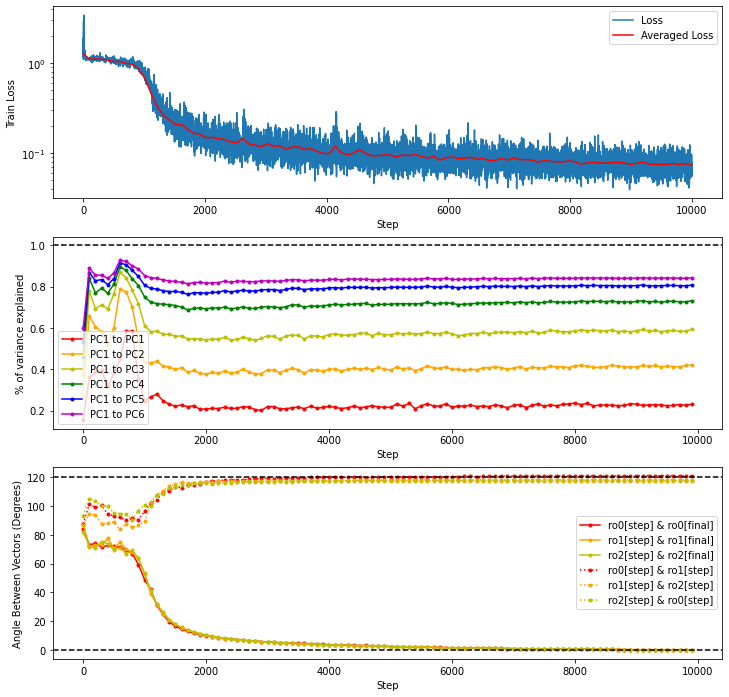

In [ ]:
pc_dims = 5
total_exvar = np.zeros((num_checkpoints, rnn_specs['hidden_size']-1))
ro_angles = np.zeros((num_checkpoints, rnn_specs['output_size']))
ro_rel_angles = np.zeros((num_checkpoints, rnn_specs['output_size']))
final_ro = readout_cps[num_checkpoints-1] # n_readouts x n_hidden

for cp in range(num_checkpoints):
  # print('Top', pc_dims, 'components:', np.sum(explained_var[cp][:pc_dims]), '(', explained_var[cp][:pc_dims],')')
  for i in range(rnn_specs['hidden_size']-1):
    total_exvar[cp][i] = np.sum(explained_var[cp][:i+1])
  for ro in range(rnn_specs['output_size']):
    dot_val = np.dot(readout_cps[cp][ro], final_ro[ro])/(np.linalg.norm(readout_cps[cp][ro])*np.linalg.norm(final_ro[ro]))
    ro_angles[cp][ro] = 180/np.pi * np.arccos(dot_val)
  for ro in range(rnn_specs['output_size']):
    ro2 = (ro+1) % rnn_specs['output_size']
    dot_val = np.dot(readout_cps[cp][ro],readout_cps[cp][ro2])/(np.linalg.norm(readout_cps[cp][ro])*np.linalg.norm(readout_cps[cp][ro2]))
    ro_rel_angles[cp][ro] = 180/np.pi * np.arccos(dot_val)
  
plt.figure(figsize=(12,12))
# ax1 = plt.subplot('131')
# ax1.plot(total_exvar[0][:20], 'k-', marker='.', label='Initial State')
# ax1.plot(total_exvar[num_checkpoints-1][:20], 'b-', marker='.', label='Final State')
# ax1.set_xlabel('PC Dimension')
# ax1.set_ylabel('% of variance explained')
# ax1.axhline(1.0, c='k', linestyle='--')
# ax1.legend()

ax1 = plt.subplot('311')
train_losses = train_params['train_losses']
n_avg = 100
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]
ax1.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses, label='Loss')
ax1.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r', label='Averaged Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Train Loss')
ax1.legend()

ax2 = plt.subplot('312')
n_pc_dims = 6
plot_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(n_pc_dims):
  ax2.plot(checkpoint_batches, total_exvar[:, i], c = plot_colors[i], marker='.', label='PC1 to PC{}'.format(i+1))
ax2.set_xlabel('Step')
ax2.set_ylabel('% of variance explained')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.legend()

ax3 = plt.subplot('313')
for i in range(rnn_specs['output_size']):
  ax3.plot(checkpoint_batches, ro_angles[:, i], c=plot_colors[i], marker='.', label='ro{}[step] & ro{}[final]'.format(i,i))
for i in range(rnn_specs['output_size']):
  ax3.plot(checkpoint_batches, ro_rel_angles[:, i], c=plot_colors[i], marker='.', linestyle='dotted',
           label='ro{}[step] & ro{}[step]'.format(i,(i+1) % rnn_specs['output_size']))

ax3.set_xlabel('Step')
ax3.set_ylabel('Angle Between Vectors (Degrees)')
ax3.axhline(0.0, c='k', linestyle='--')
ax3.axhline(180/np.pi * np.arccos(-1/(rnn_specs['output_size']-1)), c='k', linestyle='--')
ax3.legend()

### Set Readouts Tests

In [ ]:
def simplex_readouts(rand_seed, dimensions):
  """ Returns readouts which are the vertices of an n-simplex"""
  print('Initializing readouts as simplex dimensions.')
  if len(dimensions) > 2:
    raise NotImplementedError('Only current takes two dimensions, input and output')
  n_readouts = dimensions[1]
  hidden_dim = dimensions[0]
  center = np.zeros((hidden_dim,))
  for i in range(n_readouts):
    center[i] = 1/n_readouts
  readouts = np.zeros((hidden_dim, n_readouts))
  for i in range(n_readouts):
    readouts[i][i] = 1
    readouts[:,i] = center - readouts[:,i]

  return readouts

readouts = simplex_readouts(5, (128, 3)).T
print(readouts.shape)
print(readouts[0][:5])
print(readouts[1][:5])
print(readouts[2][:5])
180/np.pi*np.arccos(np.dot(readouts[0], readouts[1])/(np.linalg.norm(readouts[0]) * np.linalg.norm(readouts[1])))

Initializing readouts as simplex dimensions.
(3, 128)
[-0.66666667  0.33333333  0.33333333  0.          0.        ]
[ 0.33333333 -0.66666667  0.33333333  0.          0.        ]
[ 0.33333333  0.33333333 -0.66666667  0.          0.        ]


120.00000000000001

# Dimensions vs Number of Classes Tests

In [ ]:
n_trials = 800
class_size = [2, 3, 4, 5, 6, 7, 8, 9, 10]
states = 'Fixed' # 'Fixed Points'

unique_tol = 0.025
do_print = True

prs = np.zeros((len(class_size),))
ve_threshold_80 = np.zeros((len(class_size),))
ve_threshold_90 = np.zeros((len(class_size),))
ve_threshold_95 = np.zeros((len(class_size),))

k_val = 100
m_k_vals = np.zeros((len(class_size),))
r_range = (-0.5, 0.5)
corr_dim_vals = np.zeros((len(class_size),))
ro_theory = np.zeros((len(class_size),))
ro_angles = []
ro_plane_perc = np.zeros((len(class_size),))

for class_idx, class_num in zip(range(len(class_size)), class_size):

  # Loads network
  path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_{}classrgb_minimal_noRO_l2is2e-4.pickle'.format(class_num)

  # Loads network
  with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

  rnn_params, readout_params = params_loaded
  train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

  
  # Get RNN hidden states in response to a test batch.
  cell = build_cell(rnn_specs)
  syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])
  hs = rnn_states(syn_data_test, rnn_params)
  pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

  if states == 'Hidden':
    pts_reduced, unique_kidxs = keep_unique_fixed_points(pts, unique_tol, do_print)
  elif states == 'Fixed':
    # Average distance traveled
    avg_step_sizes = np.zeros((len(hs),))
    for hs_idx in range(len(hs)):
      hs_h0 = np.concatenate([hs[hs_idx], h0[np.newaxis, :]], axis=0)
      total_dist = 0
      for time_idx in range(hs_h0.shape[0] - 1):
        total_dist += np.sqrt(np.sum((hs_h0[time_idx+1] - hs_h0[time_idx])**2))
      avg_step_sizes[hs_idx] = total_dist/hs[hs_idx].shape[0]

    print('Mean distance:', np.mean(avg_step_sizes))

    xstar = jnp.zeros((pts.shape[0], rnn_specs['input_size']))
    fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
    fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, pts, xstar, optimizers.adam(0.01), 
                                                                tolerance=.01 * 1/2*(np.mean(avg_step_sizes))**2, num_steps=10000)

    pts_reduced, unique_kidxs = keep_unique_fixed_points(fixed_points, unique_tol, do_print)

  # PCA measures
  pca_full = PCA(n_components=rnn_specs['hidden_size'])
  _ = pca_full.fit_transform(pts_reduced)
  prs[class_idx] = participation_ratio_vector(pca_full.explained_variance_)
  explained_var = pca_full.explained_variance_ratio_
  num_fp_dims = 1
  while np.sum(explained_var[:num_fp_dims]) < 0.8:
    num_fp_dims += 1
  ve_threshold_80[class_idx] = num_fp_dims
  num_fp_dims = 1
  while np.sum(explained_var[:num_fp_dims]) < 0.9:
    num_fp_dims += 1
  ve_threshold_90[class_idx] = num_fp_dims
  num_fp_dims = 1
  while np.sum(explained_var[:num_fp_dims]) < 0.95:
    num_fp_dims += 1
  ve_threshold_95[class_idx] = num_fp_dims

  # NN based measures
  distances = pdist(pts_reduced, metric="euclidean") # n_fp * (n_fps-1) / 2
  dist_sq = squareform(distances) # n_fp x n_fp 
  distances.sort()

  m_k_vals[class_idx] = find_m_k(k_val, dist_sq)
  slope, _, _, _, _ = find_correlation_dimension(r_range, dist_sq, show_plot=False)
  corr_dim_vals[class_idx] = slope

  # Readout tests
  readout = readout_params.T

  ro_theory[class_idx] = 180/np.pi * np.arccos(-1/(class_num-1))

  angle_vals = []
  for i in range(len(readout)):
    for j in range(i):
      angle_vals.append(180/np.pi * np.arccos(np.dot(readout[i], readout[j])/
                                              (np.linalg.norm(readout[i])*np.linalg.norm(readout[j]))))
  ro_angles.append(angle_vals)
  
  subspspace_perc_vals = []
  for i in range(len(readout)):
    A = []
    for j in range(len(readout)):
      if i != j:
        A.append(readout[j])
    subspspace_perc_vals.append(subspace_perc(np.asarray(A).T, readout[i]))  
  ro_plane_perc[class_idx] = np.mean(subspspace_perc_vals)

Using GRU cell
Sythentic data generated in: 0.23 sec.


  0%|          | 0/10000 [00:00<?, ?it/s]

Mean distance: 0.9578477422827474


  0%|          | 1/10000 [00:01<3:14:30,  1.17s/it]


    Kept 16455/19600 unique fixed points with uniqueness tolerance 0.025000.
Using GRU cell
Sythentic data generated in: 0.27 sec.


  0%|          | 0/10000 [00:00<?, ?it/s]

Mean distance: 1.1146266905085318


  0%|          | 1/10000 [00:00<1:07:14,  2.48it/s]


    Kept 18191/19600 unique fixed points with uniqueness tolerance 0.025000.
Using GRU cell
Sythentic data generated in: 0.25 sec.


  0%|          | 0/10000 [00:00<?, ?it/s]

Mean distance: 1.2303391170294538


  0%|          | 1/10000 [00:00<1:09:09,  2.41it/s]


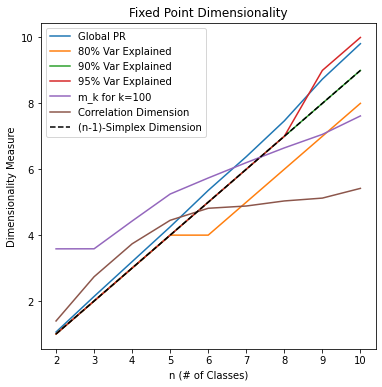

In [123]:
plt.figure(figsize=(6, 6))
plt.plot(class_size, prs, label='Global PR')
plt.plot(class_size, ve_threshold_80, label='80% Var Explained')
plt.plot(class_size, ve_threshold_90, label='90% Var Explained')
plt.plot(class_size, ve_threshold_95, label='95% Var Explained')
plt.plot(class_size, m_k_vals, label='m_k for k='+str(k_val))
plt.plot(class_size, corr_dim_vals, label='Correlation Dimension')
plt.plot(class_size, [class_val-1 for class_val in class_size], c='k', linestyle='dashed', label='(n-1)-Simplex Dimension')
if states == 'Hidden': 
  plt.title('Hidden State Dimensionality')
else:
  plt.title('Fixed Point Dimensionality')
plt.xlabel('n (# of Classes)')
plt.ylabel('Dimensionality Measure')
plt.legend()

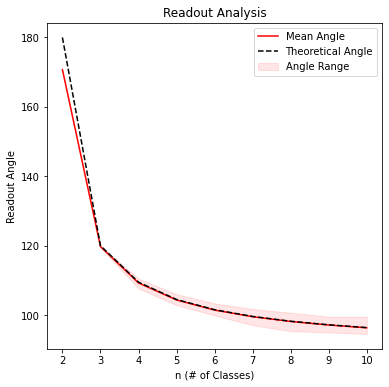

In [117]:
mean_angle = np.zeros((len(class_size),))
min_angle = np.zeros((len(class_size),))
max_angle = np.zeros((len(class_size),))
for class_idx in range(len(class_size)):
  mean_angle[class_idx] = np.mean(ro_angles[class_idx])
  min_angle[class_idx] = np.min(ro_angles[class_idx])
  max_angle[class_idx] = np.max(ro_angles[class_idx])

plt.figure(figsize=(6, 6))
plt.plot(class_size, mean_angle, c='r', label='Mean Angle')
plt.fill_between(class_size, min_angle, max_angle, color='r', alpha=0.1, label='Angle Range')
plt.plot(class_size, ro_theory, c='k', linestyle='dashed', label='Theoretical Angle')
plt.title('Readout Analysis')
plt.xlabel('n (# of Classes)')
plt.ylabel('Readout Angle')
plt.legend()

In [118]:
ro_plane_perc

0.9651803

# Bag of Words Tests

In [ ]:
def SequenceSum():
    def init_fun(_, input_shape):
        return (input_shape[0], input_shape[2]), ()
    def apply_fun(_, inputs, **kwargs):
        return jnp.sum(inputs, axis=1)
    return init_fun, apply_fun

# Loss
def xent(params, batch):
    logits = apply_fun(params, batch['inputs'])
    targets = batch['labels'][:,toy_params['phrase_length']-1]
    data_loss = -jnp.mean(jnp.sum(targets * logits, axis=1))
    reg_loss = l2_pen * renn.norm(params)
    return data_loss + reg_loss

# Accuracy
@jax.jit
def accuracy(params, batch):
    logits = apply_fun(params, batch['inputs'])
    predictions = jnp.argmax(logits, axis=1)
    target_labels = jnp.argmax(batch['labels'][:,toy_params['phrase_length']-1], axis=1)
    return jnp.mean(predictions == target_labels)

@jax.jit
def bow_step(k, opt_state, batch):
    params = get_params(opt_state)
    loss, gradients = f_df(params, batch)
    new_state = update_opt(k, gradients, opt_state)
    return new_state, loss

def test_acc(params):
    return jnp.array([accuracy(params, syn_data_test)])

In [ ]:
toy_params = {
  'phrase_length': 50,
  'loss_type': 'XE',
  'context_words' : True,
  'unordered_class': True, # Use an unordered class set
  'n_unordered': 3,
}

toy_params['words'] = generateWordBank(toy_params)
if toy_params['unordered_class']:
  toy_params['sentiments'] = ['sent'+str(i) for i in range(toy_params['n_unordered'])]
toy_params['base_word_vals'] = baseWordValues(toy_params)

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 2000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'epochs': 2,                               # How many times to go through each train set completely
  'test_set_size': 200,
}

train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs']

train_params, toy_params, rnn_specs = default_params(train_params, toy_params, {})

input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['words']))
l2_pen = 1e-3

# Linear model
init_fun, apply_fun = stax.serial(
    SequenceSum(),
    stax.Dense(len(toy_params['sentiments'])),
    stax.LogSoftmax,
)

# Initialize
key = jax.random.PRNGKey(0)
output_shape, initial_params = init_fun(key, input_shape)

f_df = jax.value_and_grad(xent)

# Train
learning_rate = optimizers.exponential_decay(2e-3, 1000, 0.8)
init_opt, update_opt, get_params = optimizers.adam(learning_rate)

state = init_opt(initial_params)
losses = []
global_step = 0
total_steps = 0
batch_size = train_params['batch_size']
num_batchs = train_params['num_batchs']

syn_data = generate_data(train_params['train_set_size'], toy_params, len(toy_params['sentiments']))
syn_data_test = generate_data(train_params['test_set_size'], toy_params, len(toy_params['sentiments']))


for epoch in range(train_params['epochs']):
  # Shuffles training data after first epoch
  if epoch > 0:
    print('Shuffling Data')
    syn_data = shuffle_data(syn_data)

  print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
  start_time = time.time()  
  avg_loss = 0 
  for step in range(total_steps, total_steps+num_batchs):
    batch = step - total_steps 
    batch_data = {
      'inputs': syn_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
      'labels': syn_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
      'index': syn_data['index'], # Target mask: list of integers up to phrase_len
    }
    
    state, loss = bow_step(global_step, state, batch_data)
    losses.append(loss)
    avg_loss += loss
    global_step += 1

    if (global_step+1) % train_params['print_every'] == 0:
      acc = np.mean(test_acc(get_params(state)))
      batch_time = time.time() - start_time
      step_size = learning_rate(global_step)
      s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
      print(s.format(global_step+1, batch_time, step_size, acc, avg_loss/train_params['print_every']))
      start_time = time.time()
      avg_loss = 0

Sythentic data generated in: 77.26 sec.
Sythentic data generated in: 0.06 sec.
Running batches 0 to 2000
Step 100 in 1.08 sec, step size: 0.00196, test acc 0.3550, avg training loss 2.5117
Step 200 in 0.29 sec, step size: 0.00191, test acc 0.3900, avg training loss 1.9194
Step 300 in 0.29 sec, step size: 0.00187, test acc 0.4100, avg training loss 1.4495
Step 400 in 0.29 sec, step size: 0.00183, test acc 0.5000, avg training loss 1.1639
Step 500 in 0.29 sec, step size: 0.00179, test acc 0.5200, avg training loss 1.0371
Step 600 in 0.28 sec, step size: 0.00175, test acc 0.5050, avg training loss 0.9894
Step 700 in 0.28 sec, step size: 0.00171, test acc 0.5550, avg training loss 0.9725
Step 800 in 0.28 sec, step size: 0.00167, test acc 0.5350, avg training loss 0.9637
Step 900 in 0.28 sec, step size: 0.00164, test acc 0.5800, avg training loss 0.9566
Step 1000 in 0.31 sec, step size: 0.00160, test acc 0.5750, avg training loss 0.9634
Step 1100 in 0.29 sec, step size: 0.00157, test acc 0.